<a id='home'></a>
# Louis Lacombe (3053198)

To best run this notebook I suggest that you run all initially. If you have downloaded the correct documents, you should have no issues as long as you run with all the files in the same folder (since we will import the data that has already been cleaned).

To run all the document, please go in the tab "Run" and go down to the selection "***Run All Cells***". :)

Once you have ran it all, you can now refer to the different sections by simply choosing which topic you want to discover:

- [***1. Data and Processing***](#data_and_processing)
    - [1.1 Some statistics before pre-processing](#stats_before)
    - [1.2 Let's do some pre-processing...](#pre-processing)
- [***2. Analysis and Visualization***](#analysis)
    - [2.1 Importing data needed](#data_import)
    - [2.2 TFIDF analysis](#tfidf)
    - [2.3 Word embeddings](#word_emb)
    - [2.4 Document embeddings](#doc_emb)
    - [2.5 Topic & Author models](#topic_models)
    - [2.6 Language models](#lang_models)
    - [2.7 Latent dimensions](#lat_dim)
    - [2.8 Clustering](#clustering)
- [***3. Conclusion***](#conclusion)



Note that in the analysis we directly provide the graph and visualization of the data.

In [1]:
import numpy as np
import pandas as pd
import sqlite3
import timeit
import spacy
import re
import string
import seaborn as sb
import nltk
import time 
import random
import multiprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import LatentDirichletAllocation
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from gensim.models import Word2Vec
from gensim.models import Doc2Vec
from gensim.models.word2vec import FAST_VERSION
from gensim.models.doc2vec import TaggedDocument
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.models.phrases import Phrases
from gensim.models import AuthorTopicModel
from gensim.corpora import Dictionary
from nltk.corpus import stopwords
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.collocations import TrigramCollocationFinder, TrigramAssocMeasures
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.decomposition import TruncatedSVD 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import silhouette_score
from sklearn import metrics
import unidecode
import csv
import contractions

# from word2number import w2n
# from nltk import SnowballStemmer
# from bs4 import BeautifulSoup
# from gensim.test.utils import datapath, temporary_file

nlp = spacy.load('en_core_web_sm')
random.seed(0)

<a id='data_and_processing'></a>
# 1. Data and Preprocessing (5 pts)
[Back to table of contents](#home)

Pick a data set with **at least 5,000** documents that you have found yourself.
Briefly (max. 100 words!) describe the content and type of the data set (book, reviews, Twitter, ...). 

Preprocess the data and explain (max. 200 words) which preprocessing steps you chose and why, and give statistics of the number of documents, types, and tokens, before and after preprocessing.

The data set was found on the following kaggle page: "https://www.kaggle.com/jrobischon/wikipedia-movie-plots". It contains movie plots/synopsis of various and the genre, title and many other attributes. In my case, I will only pay attention to the genre and the plots.

First some useful methods I will use throughout the document:

In [2]:
# Some method I will need at times to have correct input into functions
def getting_specific_text_list(name):
    return data_set_used[data_set_used[column_with_text]==name].tolist()

# Some method I will need at times to have correct input into functions
def text_to_list_list(text):
    all_list = []
    for sentence in text:
        all_list.append(sentence.split(sep=None, maxsplit=-1))
    return all_list

# Some method I will need at times to have correct input into functions
def list_list_to_list(list_1):
    big_list = []
    for x in list_1:
        text_1 = ""
        for y in x:
            text_1 = text_1+" "+y
        text_1.lstrip()
        big_list.append(text_1)
    return big_list
    
# Function to remove accents
def remove_accented_chars(text):
    """remove accented characters from text, e.g. café"""
    text = unidecode.unidecode(text)
    return text

# Function to remove punctuation
punctuation = re.compile('[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]')
def removing_punctuation(text): #me
    return re.sub(punctuation, "", text)

# Function to remove numbers
numbers = re.compile('\d')
def removing_numbers(text):
    return re.sub(numbers, "", text) 

# Function to clean words
def cleaning_word(text):
    text = text.lower()
    text = removing_punctuation(text)
    text = remove_accented_chars(text)
    text = removing_numbers(text)
    text = removing_punctuation(text) #used twice because sometimes they are around numbers...
    return text

# Making a quick way to make barcharts
def making_bar_chart(x, y, xlabel, ylabel, title):
    plt.xticks(range(len(x)), y, rotation = 90)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.bar(range(len(x)), x) 
    plt.savefig("Pictures/"+title, dpi=300)
    plt.show()

<a id='stats_before'></a>
## 1.1 Some statistics before pre-processing 
[Back to table of contents](#home)

Reading the database and already dropping some things I will no longer use later...

In [3]:
df = pd.read_csv('wiki_movie_plots_deduped.csv').drop(['Title', 'Release Year', 'Origin/Ethnicity','Cast', 'Wiki Page', 'Director'], axis=1)
column_with_text = "Plot"
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Genre   34886 non-null  object
 1   Plot    34886 non-null  object
dtypes: object(2)
memory usage: 545.2+ KB


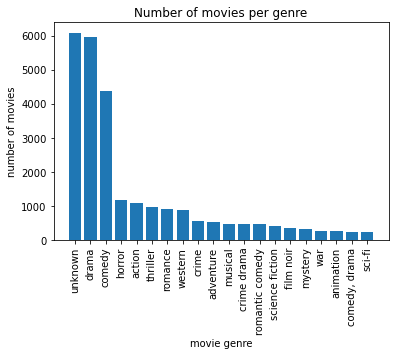

In [4]:
genres = df.groupby('Genre').size().sort_values(0, ascending=False).reset_index().rename(columns={0: "size"})
genres_20 = genres['Genre'][:20]
num_plots = genres['size'][:20]

making_bar_chart(num_plots, genres_20, 'movie genre', 'number of movies', 'Number of movies per genre')

In [5]:
all_text = df['Plot'].tolist()
vectorizer = CountVectorizer(analyzer='word')
print("Total number words: ", sum(vectorizer.fit_transform(all_text).sum(axis=0).A1))
print("Number of unique words: ", vectorizer.fit_transform(all_text).shape[1])

Total number words:  12691305
Number of unique words:  133863


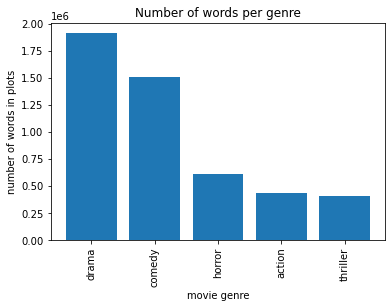

In [6]:
num_words = []
for genre in genres_20[1:6]:
    all_text = df[df["Genre"]==genre]['Plot'].tolist()
    num_words.append(sum(vectorizer.fit_transform(all_text).sum(axis=0).A1))
    
making_bar_chart(num_words, genres_20[1:6], 'movie genre', 'number of words in plots', 'Number of words per genre')

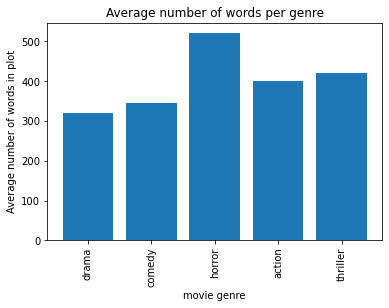

In [7]:
making_bar_chart(num_words/num_plots[1:6], genres_20[1:6], 'movie genre', 'Average number of words in plot', 'Average number of words per genre')

In [8]:
words = [word for document in text_to_list_list(all_text) for word in document]

finder = BigramCollocationFinder.from_words(words)
bgm = BigramAssocMeasures()
score = bgm.mi_like
scored = finder.score_ngrams(bgm.mi_like)

collocations = {'_'.join(bigram): pmi 
                for bigram, pmi in finder.score_ngrams(score)}
Counter(collocations).most_common(10)

[('New_York', 57.6),
 ('in_the', 46.35394363528964),
 ('of_the', 44.42452915106116),
 ('has_been', 34.270057756533994),
 ('does_not', 25.011474003422475),
 ('that_he', 24.642157914693982),
 ('to_be', 16.618142271904137),
 ('United_States', 15.574074074074074),
 ('Air_Force', 15.515151515151516),
 ('Secret_Service', 14.626373626373626)]

In [9]:
finder = TrigramCollocationFinder.from_words(words)
bgm = BigramAssocMeasures()
score = bgm.mi_like

collocations = {'_'.join(bigram): pmi 
                for bigram, pmi in finder.score_ngrams(score)}
Counter(collocations).most_common(10)

[('"Benny"_Chacón_(Lobo', 1.0),
 ('"CRASH_AND_BURN."', 1.0),
 ('"Cereal_Killer"_Goldstein', 1.0),
 ('"Championship_X"_(Ten)', 1.0),
 ('"Demi"_Zubov_(Harris)', 1.0),
 ('"Dottie"_Vail_(Jan', 1.0),
 ('"Executive_Development_Training",', 1.0),
 ('"Forgive_Me,_Kathleen"', 1.0),
 ('"Frankie"_(Irina_Apeksimova),', 1.0),
 ('"French_furniture"_(code', 1.0)]

From the graphs we can clearly see some cleaning needs to be done as there is a large discrepancy between some genres and additionally there are many unkonwns. We can also observe from the bi-grams and tri-grams that there are a few if not many words that are not of interest or evern should be accounted as the same word as oppose to two distinc words. A clear example is New-York... Finally in the tri-grams we can see that there are many words that are found once, they don't really have meaning, most of them are just names and none-sense, not interesting for our analysis. Hence we will need to do some cleaning before we can apply any models.

<a id='pre-processing'></a>
## 1.2 Let's do some pre-processing... 
[Back to table of contents](#home)

In [10]:
# remove empty entries
for x in df.columns:
    df = df[df[x].notnull()]
    df = df[df[x]!="unknown"]
    df = df[df[x]!="Unknown"]
    

# make sure everything is a string
df[column_with_text] = df[column_with_text].astype(str)
df = df.drop_duplicates(subset=['Plot'])

df = df.reset_index().drop(['index'],axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28351 entries, 0 to 28350
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Genre   28351 non-null  object
 1   Plot    28351 non-null  object
dtypes: object(2)
memory usage: 443.1+ KB


We see that there are too many categories to be interesting, hence, we will only look at the first 10 genres.

In [11]:
removed_genres = df.groupby('Genre').size().sort_values(ascending=False).reset_index()[10:]['Genre'].values

# remove empty entries
for x in removed_genres:
    df = df[df['Genre']!=x]
    
df = df.reset_index().drop(['index'],axis=1)
df

Genre                                               Plot
0      western  The film opens with two bandits breaking into ...
1       comedy  The film is about a family who move to the sub...
2       comedy  Before heading out to a baseball game at a nea...
3       comedy  The plot is that of a black woman going to the...
4        drama  On a beautiful summer day a father and mother ...
...        ...                                                ...
16701    drama  Hasan is a twelve-year-old boy living with his...
16702    drama  Through the night, three cars carry a small gr...
16703    drama  The film opens with a Senegalese boy named Kha...
16704   comedy  Two musicians, Salih and Gürkan, described the...
16705   comedy  Zafer, a sailor living with his mother Döndü i...

[16706 rows x 2 columns]

In [12]:
df1 = df.copy()
all_text = df1[column_with_text].tolist()

print("The number unique plots: ", len(df1[column_with_text].unique()))
print("The number words: ", sum(vectorizer.fit_transform(all_text).sum(axis=0).A1))
print("Number of unique words: ", vectorizer.fit_transform(all_text).shape[1])

The number unique plots:  16706
The number words:  5787398
Number of unique words:  88092


In [13]:
data_set_used = df1.copy()
all_text = data_set_used[column_with_text].tolist()
text_comedy = data_set_used[data_set_used['Genre']=="comedy"][column_with_text].tolist()
text_action = data_set_used[data_set_used['Genre']=="action"][column_with_text].tolist()
text_horror = data_set_used[data_set_used['Genre']=="horror"][column_with_text].tolist()
text_thriller = data_set_used[data_set_used['Genre']=="thriller"][column_with_text].tolist()
text_drama = data_set_used[data_set_used['Genre']=="drama"][column_with_text].tolist()

### DO NOT RUN THIS, TAKES TOO LONG!!

There are multiple iterations of this step. I would strongly suggest to go to the start of the data analysis and run from there...

In [14]:
# #Here we will proceed to multiple types of cleaning methods

# # put predefined stopwords in a set for faster lookup
# stopwords_ = set(stopwords.words('english'))
# stopwords_.add("film")
# stopwords_.add("movie")

# lemmas = [
#     [token.lemma_ for token in nlp(sentence)]
#     for sentence in all_text
# ]

# print("Lemmas done") #We do lemmas because I found stemming too strong and lemmatization still keeps most of the understanding of the word

# pos = [
#     [token.pos_ for token in nlp(sentence)] 
#     for sentence in all_text
# ]

# print("pos done") #Looking at which position the word holds because we will have a datasets with different types of words

# ents = [
#     [token.label_ for token in nlp(sentence).ents] 
#     for sentence in all_text
# ]

# print("ents done") #We want to get rid of any word which could represent an organization or just words that are specific to something such as "Apple" our aim is to get an overall understanding not of some specific words

# v2_all_text = []

# for i in range(len(lemmas)):
#     filtered_list = []
#     nlp_sentence = nlp(all_text[i])
#     lemmas_sentence = lemmas[i]
#     for j in range(len(lemmas_sentence)):    
#         word = cleaning_word(lemmas_sentence[j]) #we clean according to method previously established
#         if ((len(word) > 2) and (word not in stopwords_) #we want to make sure not to include any stopwords or small words (that actually have no meaning such as "a")
#             and ((pos[i][j]=="VERB") or (pos[i][j]=="NOUN") or (pos[i][j]=="ADV") or (pos[i][j]=="ADJ")) #this can be done if we want to keep verbs and adverbs
# #             and ((pos[i][j]=="NOUN") or (pos[i][j]=="ADJ")) 
#             and (nlp_sentence[j].ent_type_=='')):
#             filtered_list.append(word)
#     filtered_sentence = (" ").join(filtered_list)
#     v2_all_text.append(filtered_sentence)

In [15]:
# words = [word for document in text_to_list_list(v2_all_text) for word in document]

# finder = BigramCollocationFinder.from_words(words)
# bgm = BigramAssocMeasures()
# score = bgm.mi_like
# scored = finder.score_ngrams(bgm.mi_like)

# collocations = {'_'.join(bigram): pmi 
#                 for bigram, pmi in finder.score_ngrams(score)}
# Counter(collocations).most_common(25)

Possibly words that actually belong together that shouldn't be two words, but one...
We choose to do 25 words in general as this seems to incorporate some of the most important ones, unfortunately it also takes into account some that should be separated, but as a rule of thumb, this works quite well.

In [16]:
# for i in range(len(v2_all_text)):
#     for y in scored[:25]:
#         b1 = y[0][0]
#         b2 = y[0][1]
#         v2_all_text[i] = v2_all_text[i].replace("%s %s" % (b1, b2), "%s_%s" % (b1, b2))

In [17]:
# finder = TrigramCollocationFinder.from_words(words)
# bgm = BigramAssocMeasures()
# score = bgm.mi_like

# collocations = {'_'.join(bigram): pmi 
#                 for bigram, pmi in finder.score_ngrams(score)}
# Counter(collocations).most_common(30)

In [18]:
# with open("randombla.csv", 'w', newline='') as myfile:
#      wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
#      wr.writerow(v2_all_text)

<a id='analysis'></a>
# 2. Analysis and Visualization (15 pts) + (10 pts)
[Back to table of contents](#home)

Describe what question you are investigating with the data (max. 100 words).

Use at least **five** of the following analysis methods to the data set (justify your choices and make them explicit):

* Word embeddings 
* Document embeddings
* TFIDF analysis
* Topic models
* Dimensionality reduction
* Clustering
* Language models

Justify your choice of the number of latent dimensions/topics/clusters!

Your analysis needs to be run on **at least 5,000** preprocessed documents!

If appropriate for your problem, feel free to explore other methods we discussed (NER, parsing, POS, etc.), or algorithms not covered in class (e.g., clustering algorithms, etc.), as long as they do not require additional libraries (up to 2 bonus points).

***
***

***Research Question***: Our aim during this analysis will be to see if we can differentiate the genre of movies according to their plots. We will specifically look more closely into 5 different genres, namely, comedy, action, horror, thriller and drama. Additionally, we will look at some of the differences when we add verbs and adverbs or if we leave them out.

<a id='data_import'></a>
## 2.1 Importing the data we need 
[Back to table of contents](#home)

In [19]:
# Importing the new cleaned plots and linking it up with our previous data 
data_set_used["processed_plots"] = pd.DataFrame(pd.read_csv("full_list_with_ents_add_stopwords_only_noun_adj.csv").columns.to_list()).rename(columns={0: "simple_plots"})
num_documents = data_set_used.shape[0]

In [20]:
# Naming categories that we may later come to use...
data_comedy = data_set_used[data_set_used['Genre']=="comedy"].reset_index().drop(['index'], axis=1)["processed_plots"].tolist()
data_action = data_set_used[data_set_used['Genre']=="action"].reset_index().drop(['index'], axis=1)["processed_plots"].tolist()
data_horror = data_set_used[data_set_used['Genre']=="horror"].reset_index().drop(['index'], axis=1)["processed_plots"].tolist()
data_thriller = data_set_used[data_set_used['Genre']=="thriller"].reset_index().drop(['index'], axis=1)["processed_plots"].tolist()
data_drama = data_set_used[data_set_used['Genre']=="drama"].reset_index().drop(['index'], axis=1)["processed_plots"].tolist()
data_text = data_set_used["processed_plots"].tolist()

words_comedy = [word for document in text_to_list_list(data_comedy) for word in document]
words_action = [word for document in text_to_list_list(data_action) for word in document]
words_horror = [word for document in text_to_list_list(data_horror) for word in document]
words_thriller = [word for document in text_to_list_list(data_thriller) for word in document]
words_drama = [word for document in text_to_list_list(data_drama) for word in document]
all_words = [word for document in text_to_list_list(data_text) for word in document]

In [21]:
# Naming different vectors that will come to use later...

diff_cat = ["comedy", "action", "horror", "thriller", "drama"]
data_diff_cat = [data_comedy, data_action, data_horror, data_thriller, data_drama]
words_diff_cat = [words_comedy, words_action, words_horror, words_thriller, words_drama]
words = [word for document in text_to_list_list(all_words) for word in document]

In [22]:
# A different set of cleaned plots but this time including verbs and adverbs
data_set_used["processed_plots_with_verbs"] = pd.DataFrame(pd.read_csv("full_list_with_ents_add_stopwords.csv").columns.to_list()).rename(columns={0: "simple_plots"})
num_documents = data_set_used.shape[0]

In [23]:
# Naming categories that we may later come to use...

data_comedy_with_verbs = data_set_used[data_set_used['Genre']=="comedy"].reset_index().drop(['index'], axis=1)["processed_plots_with_verbs"].tolist()
data_action_with_verbs = data_set_used[data_set_used['Genre']=="action"].reset_index().drop(['index'], axis=1)["processed_plots_with_verbs"].tolist()
data_horror_with_verbs = data_set_used[data_set_used['Genre']=="horror"].reset_index().drop(['index'], axis=1)["processed_plots_with_verbs"].tolist()
data_thriller_with_verbs = data_set_used[data_set_used['Genre']=="thriller"].reset_index().drop(['index'], axis=1)["processed_plots_with_verbs"].tolist()
data_drama_with_verbs = data_set_used[data_set_used['Genre']=="drama"].reset_index().drop(['index'], axis=1)["processed_plots_with_verbs"].tolist()
data_text_with_verbs = data_set_used["processed_plots_with_verbs"].tolist()

words_comedy_with_verbs = [word for document in text_to_list_list(data_comedy_with_verbs) for word in document]
words_action_with_verbs = [word for document in text_to_list_list(data_action_with_verbs) for word in document]
words_horror_with_verbs = [word for document in text_to_list_list(data_horror_with_verbs) for word in document]
words_thriller_with_verbs = [word for document in text_to_list_list(data_thriller_with_verbs) for word in document]
words_drama_with_verbs = [word for document in text_to_list_list(data_drama_with_verbs) for word in document]
all_words_with_verbs = [word for document in text_to_list_list(data_text_with_verbs) for word in document]

In [24]:
# Naming different vectors that will come to use later...

data_diff_cat_with_verbs = [data_comedy_with_verbs, data_action_with_verbs, data_horror_with_verbs, data_thriller_with_verbs, data_drama_with_verbs]
words_diff_cat_with_verbs = [words_comedy_with_verbs, words_action_with_verbs, words_horror_with_verbs, words_thriller_with_verbs, words_drama_with_verbs]
words_with_verbs = [word for document in text_to_list_list(all_words_with_verbs) for word in document]

Checking the new number of movies by genre

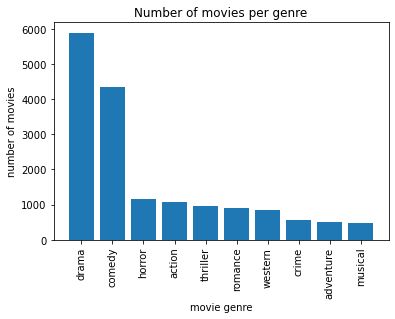

In [25]:
genres = data_set_used.groupby('Genre').size().sort_values(0, ascending=False).reset_index().rename(columns={0: "size"})
genres_20 = genres['Genre'][:20]
num_plots = genres['size'][:20]

making_bar_chart(num_plots, genres_20, 'movie genre', 'number of movies', 'Number of movies per genre')

Now we look at statistics about the data given all the cleaning when we use only adjectives and nouns.

In [26]:
all_text = data_set_used['processed_plots'].tolist()
print(all_text[0])
vectorizer = CountVectorizer(analyzer='word')
print("Total number words: ", sum(vectorizer.fit_transform(all_text).sum(axis=0).A1))
print("Number of unique words: ", vectorizer.fit_transform(all_text).shape[1])

bandit railroad telegraph office operator gunpoint train order engineer locomotive tender station water tank operator train banditsnow bandit express car messenger box valuable dynamite fireman engineer train locomotive bandit passenger train belonging passenger loot bandit locomotive valley horse telegraph office operator awaken daughter meal free consciousness water comic relief dance hall stranger local foot door telegraph operator robbery man posse bandit final shootout mail
Total number words:  1289290
Number of unique words:  27111


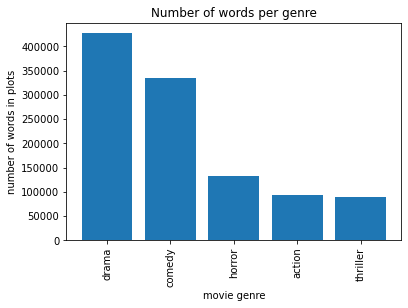

In [27]:
num_words = []
for genre in genres_20[0:5]:
    all_text = data_set_used[data_set_used["Genre"]==genre]['processed_plots'].tolist()
    num_words.append(sum(vectorizer.fit_transform(all_text).sum(axis=0).A1))
    
making_bar_chart(num_words, genres_20[0:5], 'movie genre', 'number of words in plots', 'Number of words per genre')

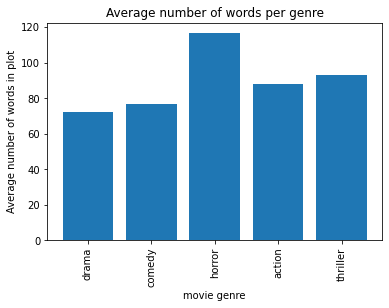

In [28]:
making_bar_chart(num_words/num_plots[0:5], genres_20[0:5], 'movie genre', 'Average number of words in plot', 'Average number of words per genre')

Now we look at statistics about the data given all the cleaning when we use verbs, adverbs, adjectives and nouns. We can see our cleaning has cut out a lot of words, when observing the sentences more closely, it can be observed that indeed the word cut has been quite useful and efficient.

In [29]:
all_text = data_set_used['processed_plots_with_verbs'].tolist()
print(all_text[0])
vectorizer = CountVectorizer(analyzer='word')
print("Total number words: ", sum(vectorizer.fit_transform(all_text).sum(axis=0).A1))
print("Number of unique words: ", vectorizer.fit_transform(all_text).shape[1])

open bandit break railroad telegraph office force operator gunpoint train stop transmit order engineer fill locomotive tender station water tank knock operator tie train stop board banditsnow bandit enter express car kill messenger open box valuable dynamite kill fireman force engineer halt train disconnect locomotive bandit force passenger train rifle belonging passenger try escape instantly shoot carry loot bandit escape locomotive later stop valley horse leave meanwhile back telegraph office bind operator awaken collapse daughter arrive bring meal cut free restore consciousness douse water comic relief dance hall stranger force dance local fire foot door suddenly open telegraph operator rush tell robbery man quickly form posse overtake bandit final shootout kill recover steal mail
Total number words:  2303978
Number of unique words:  31492


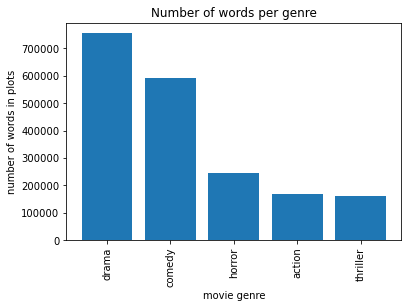

In [30]:
num_words = []
for genre in genres_20[0:5]:
    all_text = data_set_used[data_set_used["Genre"]==genre]['processed_plots_with_verbs'].tolist()
    num_words.append(sum(vectorizer.fit_transform(all_text).sum(axis=0).A1))
    
making_bar_chart(num_words, genres_20[0:5], 'movie genre', 'number of words in plots', 'Number of words per genre')

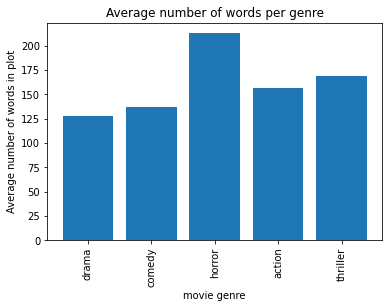

In [31]:
making_bar_chart(num_words/num_plots[0:5], genres_20[0:5], 'movie genre', 'Average number of words in plot', 'Average number of words per genre')

Quickly checking which words match which...
Also specifying a filter...
Interesting to observe some of the differences between each categories...

Note the choice for the word "man" is explained later (it's the most used word in our data)

In [32]:
for i in range(len(words_diff_cat)):
    # Ngrams with 'creature' as a member
    creature_filter = lambda *w: 'man' not in w
    ## Bigrams
    finder = BigramCollocationFinder.from_words(words_diff_cat[i])
    finder.apply_ngram_filter(creature_filter)
    bgm = BigramAssocMeasures()
    score = bgm.mi_like

    collocations = {'_'.join(bigram): pmi 
                    for bigram, pmi in finder.score_ngrams(score)}
    print("This is for: ", diff_cat[i], " ", Counter(collocations).most_common(5))

This is for:  comedy   [('young_man', 1.5172035906375956), ('con_man', 0.17954068261981795), ('old_man', 0.07486954816310253), ('homeless_man', 0.03399853279403601), ('lady_man', 0.02570763272135828)]
This is for:  action   [('hand_man', 0.15406558849955077), ('young_man', 0.08641227324263039), ('old_man', 0.04073275862068965), ('homeless_man', 0.020416666666666666), ('hit_man', 0.018996960486322188)]
This is for:  horror   [('old_man', 0.4773987074872031), ('young_man', 0.2976007043803654), ('mysterious_man', 0.025696816272732504), ('wicker_man', 0.020812520812520812), ('man_suit', 0.01649962940285521)]
This is for:  thriller   [('young_man', 0.2872694820210429), ('hooded_man', 0.059297912713472484), ('dead_man', 0.041669333504010926), ('old_man', 0.033728363493312354), ('mysterious_man', 0.02049335863377609)]
This is for:  drama   [('young_man', 6.135845978117086), ('old_man', 0.94461363590873), ('rich_man', 0.0765541303793317), ('black_man', 0.05657499081740917), ('white_man', 0.038

In [33]:
# Ngrams with 'creature' as a member
creature_filter = lambda *w: 'man' not in w
## Bigrams
finder = TrigramCollocationFinder.from_words(words)
finder.apply_ngram_filter(creature_filter)
bgm = BigramAssocMeasures()
score = bgm.mi_like

collocations = {'_'.join(bigram): pmi 
                for bigram, pmi in finder.score_ngrams(score)}
Counter(collocations).most_common(10)

[('carom_man_nympho', 7.633587786259542e-05),
 ('flim_flam_man', 7.633587786259542e-05),
 ('man_sharaf_padmasoorya', 7.633587786259542e-05),
 ('man_reavel_gabbar', 3.816793893129771e-05),
 ('seaweed_balfour_man', 3.816793893129771e-05),
 ('right_hand_man', 3.063292160869643e-05),
 ('collapsible_man_yate', 2.544529262086514e-05),
 ('man_Unnamed:_16487', 2.544529262086514e-05),
 ('man_ronin_masterless', 2.544529262086514e-05),
 ('two_gregarious_man', 2.544529262086514e-05)]

<a id='tfidf'></a>
## 2.2 TFIDF analysis 
[Back to table of contents](#home)

We will run this analysis to have a better understanding of the data at hand, additionally, this will also give us a clearer view of what is at play and we might possibly use some words found here as later inputs.

In [34]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word', 
                                   min_df=0.001, 
                                   max_df=0.75, 
                                   stop_words='english', 
                                   sublinear_tf=True) #this is to get the raw counts, like just this lines...
X = tfidf_vectorizer.fit_transform(data_text)

vectorizer = CountVectorizer(analyzer='word', 
                             min_df=0.001, 
                             max_df=0.75, 
                             stop_words='english')
X2 = vectorizer.fit_transform(data_text)

df_tfidf = pd.DataFrame(data={'word': vectorizer.get_feature_names(), 
                        'tf': X2.sum(axis=0).A1, 
                        'idf': tfidf_vectorizer.idf_,
                        'tfidf': X.sum(axis=0).A1
                   }).sort_values(['tfidf', 'tf', 'idf']).reset_index().drop(['index'], axis=1) # sort by TFIDF, then TF, then IDF

In [35]:
most_important_words = df_tfidf['word'][-5:].values #to keep for later
most_important_word = df_tfidf['word'][-1:].values[0] #to keep for later
df_tfidf

word     tf       idf       tfidf
0           kneel     17  7.833211    1.979450
1     consecutive     17  7.833211    2.109753
2           surly     17  7.833211    2.112400
3           pulse     17  7.833211    2.138196
4           brown     18  7.779144    2.159359
...           ...    ...       ...         ...
5814       family   8174  2.422558  367.559951
5815         life   8439  2.129429  392.122554
5816         love   7617  2.248254  405.664739
5817       father  10358  2.258736  407.026862
5818          man  13100  1.943718  457.335454

[5819 rows x 4 columns]

Showing idf vs tfidf with marker as proportionality of tf...

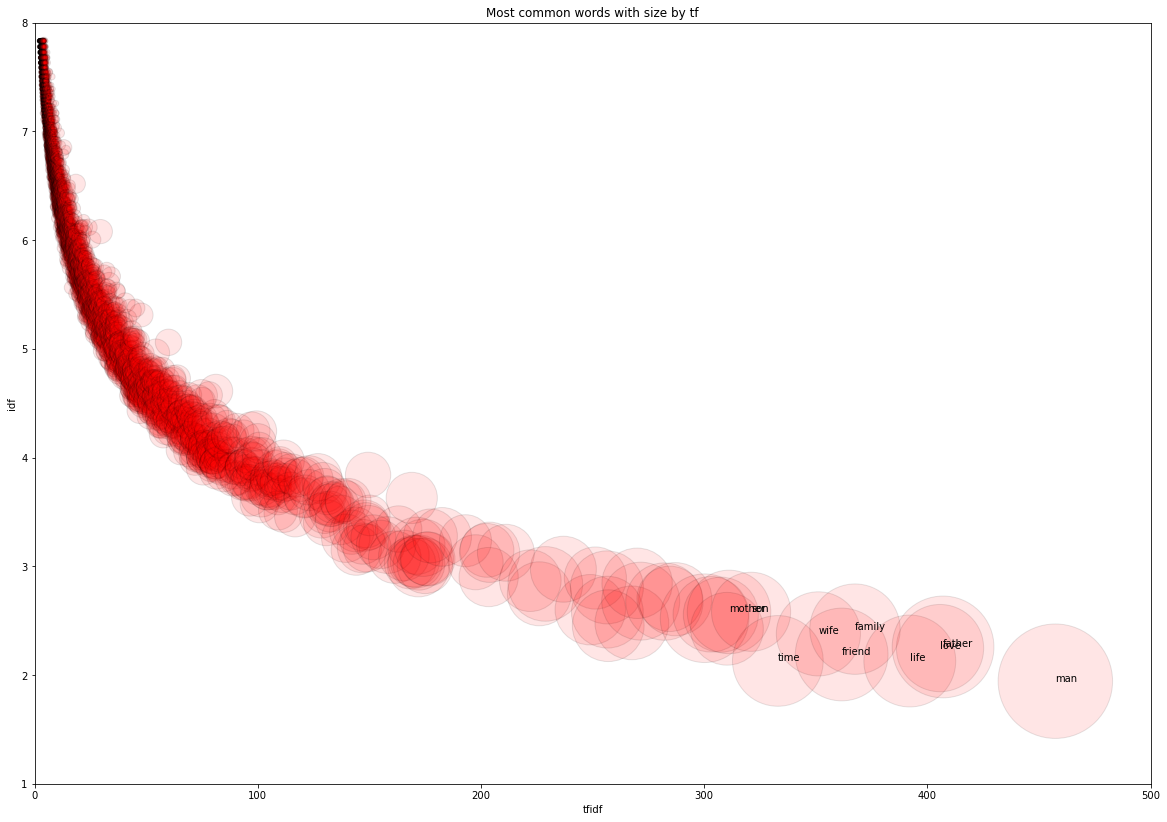

In [36]:
fig, ax = plt.subplots(figsize = (20,14))

x = df_tfidf.tfidf
y = df_tfidf.idf
s = df_tfidf.tf
word = df_tfidf.word

df_tfidf.plot.scatter(x = 'tfidf',
                        y = 'idf',
                        s = 'tf',
                        ax = ax,
                        alpha = 0.1,
                        edgecolor = 'black',
                        color = 'red',
                        ylim = (1,8),
                        xlim = (0,500));

for i in range(df_tfidf.shape[0]-10, df_tfidf.shape[0]):
    plt.text(x[i], y[i], word[i])
plt.title('Most common words with size by tf')
plt.savefig("Pictures/Most common words with size by tf", dpi=300)
plt.show()

Plot of most popular 20 words

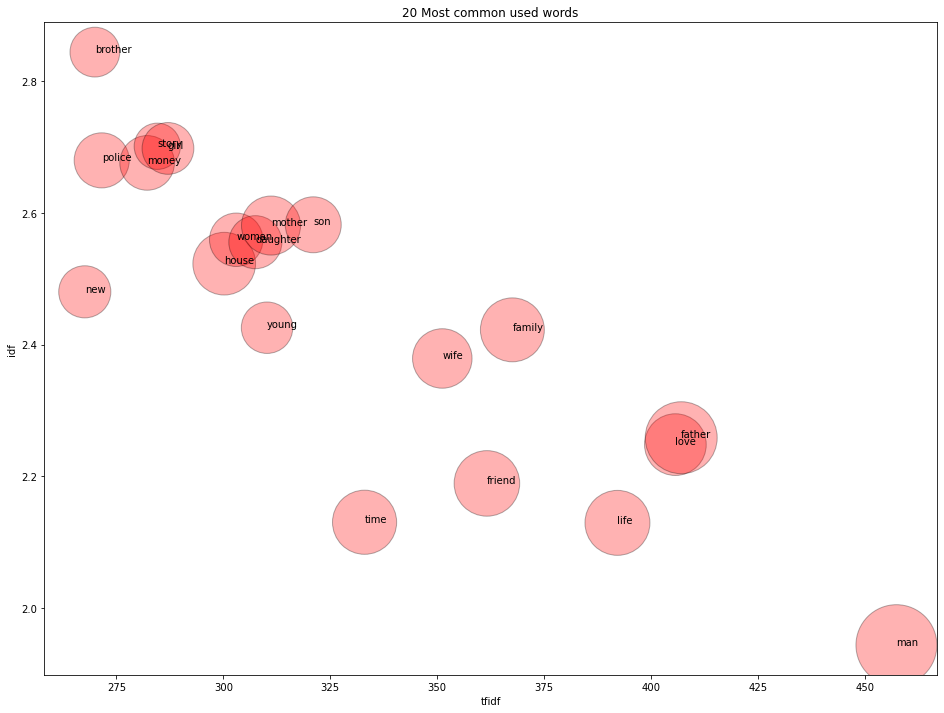

In [37]:
fig, ax = plt.subplots(figsize = (16,12))

df_tfidf['tf'] /= 2

df_tfidf.iloc[df_tfidf.shape[0]-20:df_tfidf.shape[0],:].plot.scatter(x = 'tfidf',
                        y = 'idf',
                        s = 'tf',
                        ax = ax,
                        alpha = 0.3,
                        edgecolor = 'black',
                        color = 'red');

for label, x, y in zip(df_tfidf.iloc[df_tfidf.shape[0]-20:df_tfidf.shape[0],0], df_tfidf.iloc[df_tfidf.shape[0]-20:df_tfidf.shape[0],3], df_tfidf.iloc[df_tfidf.shape[0]-20:df_tfidf.shape[0],2]):
            txt = plt.annotate(label,xy=(x, y))
        
df_tfidf['tf'] *= 2

plt.title("20 Most common used words")
plt.savefig("Pictures/20 Most common used words", dpi=300)
plt.show()

Specific for each genre most important words according to tfidf

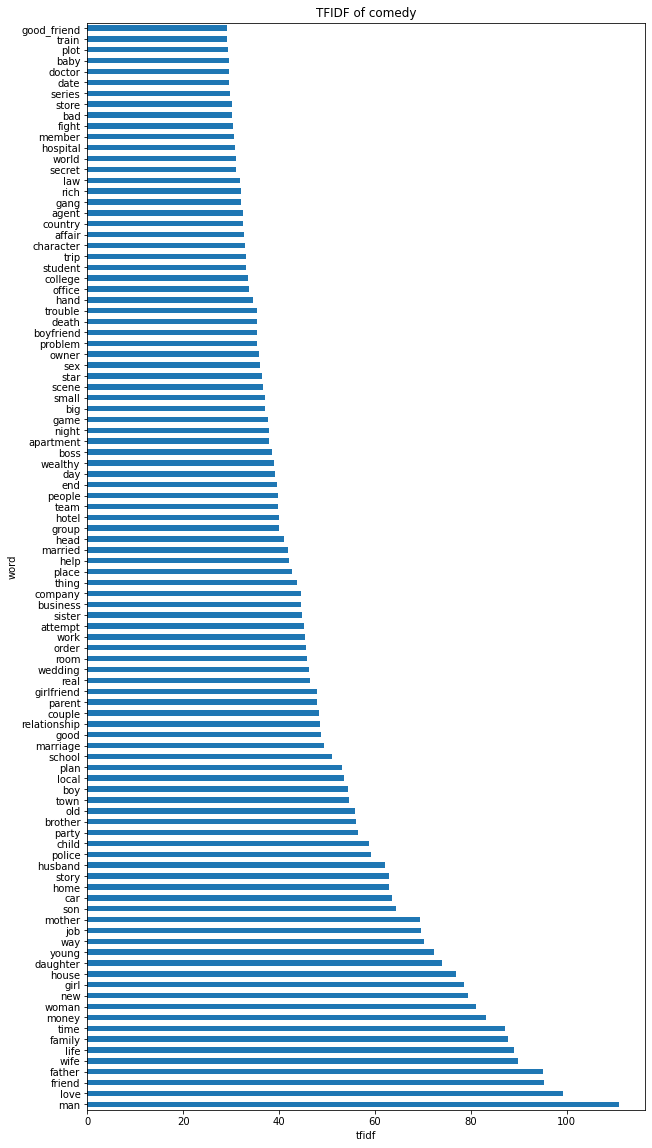

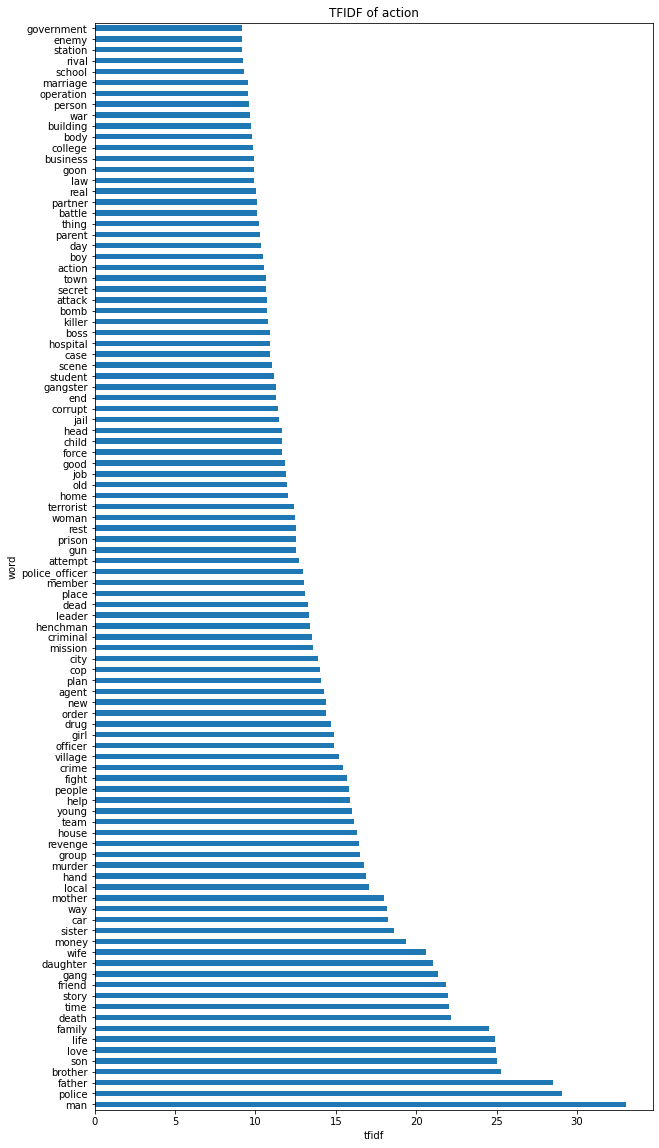

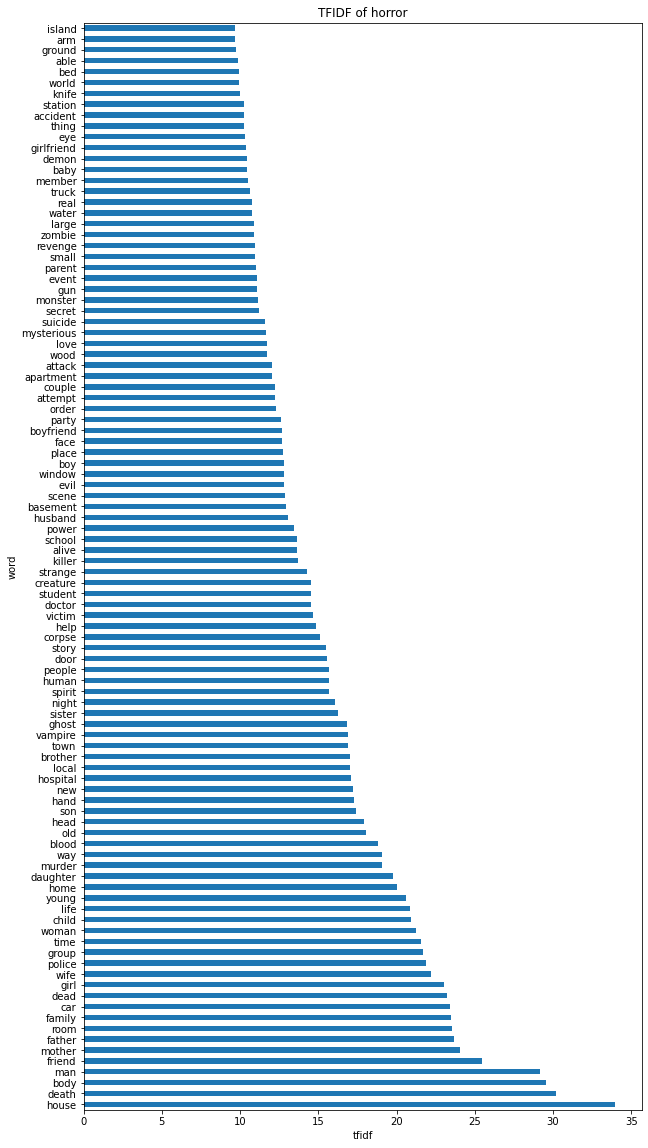

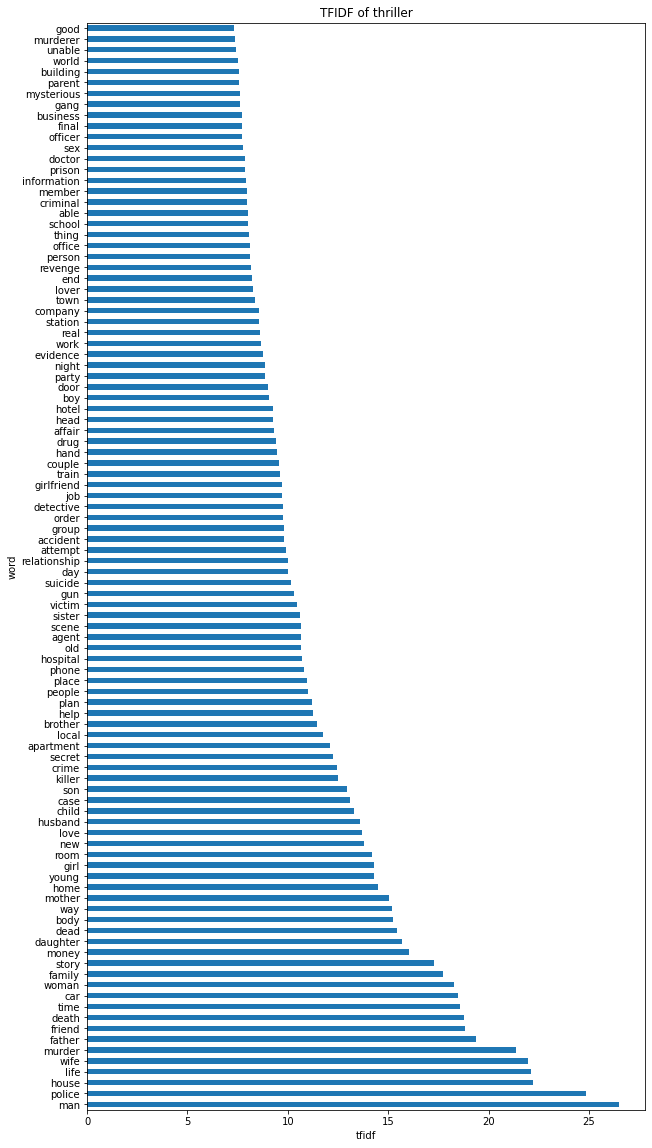

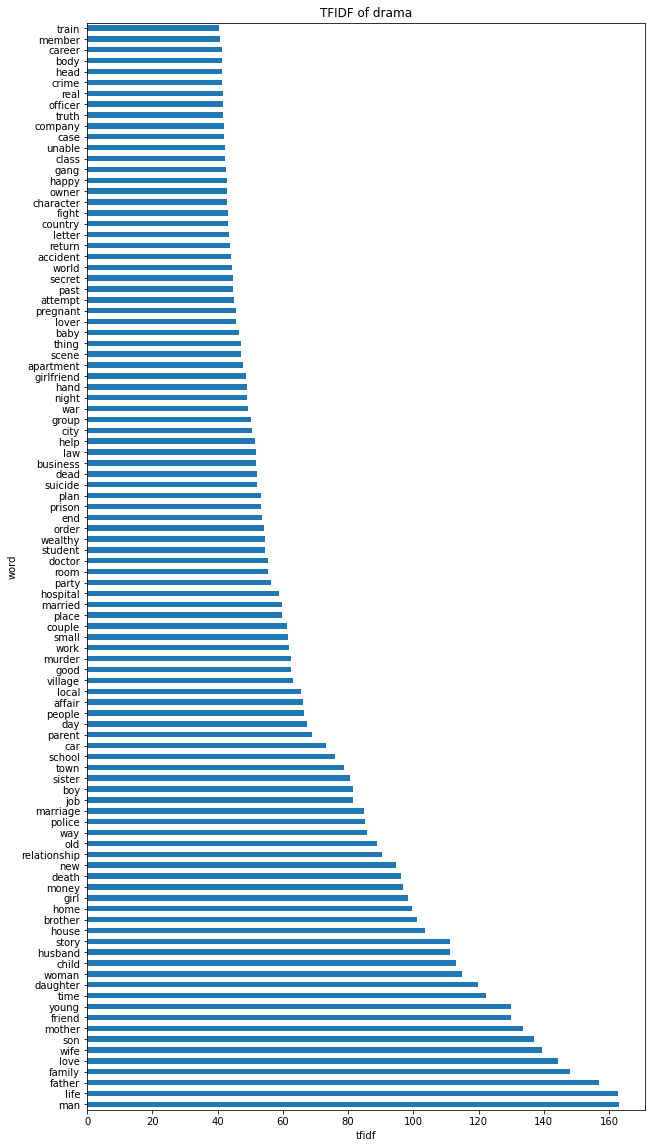

In [38]:
for i in range(len(data_diff_cat)):
    X = tfidf_vectorizer.fit_transform(data_diff_cat[i])
    X2 = vectorizer.fit_transform(data_diff_cat[i])
    df_tfidf = pd.DataFrame(data={'word': vectorizer.get_feature_names(), 
                        'tf': X2.sum(axis=0).A1, 
                        'idf': tfidf_vectorizer.idf_,
                        'tfidf': X.sum(axis=0).A1
                   }).sort_values(['tfidf', 'tf', 'idf'], ascending=False).reset_index().drop(['index'], axis=1)
    df_tfidf = df_tfidf.set_index('word')
    fig, ax = plt.subplots(figsize = (10,20))
    df_tfidf['tfidf'][:100].plot.barh(ax = ax,
                                  xlabel='word')
    ax.set_title('TFIDF of '+ diff_cat[i])
    ax.set_xlabel('tfidf')
    plt.savefig('Pictures/TFIDF of '+ diff_cat[i], dpi=300)
    plt.show()

<a id='word_emb'></a>
## 2.3 Word embeddings 
[Back to table of contents](#home)

Word embeddings are really interesting, the idea here will be to observe if we can see differences between each genre, how the words are used in a similar or different context throughout different genres.

In [39]:
# Function to train model
def train_word2vec(filename):
    corpus = [document.split() for document in filename]

    w2v_model = Word2Vec(size=100, 
                    window=50, #our sampling window has been specifically chosen due to the number of words we have per plots
                    sample=0.0001, 
                    iter=200, 
                    negative=5, 
                    min_count=200, #the min count has been chosen quite arbitrarily but with the hope that any words that aren't meaningfull would get cut-off then
                    workers=-1, 
                    hs=0 
    )
    w2v_model.build_vocab(corpus)
    w2v_model.train(corpus, 
                    total_examples=w2v_model.corpus_count, 
                    epochs=w2v_model.epochs)
    return w2v_model

# Function to make some plots
def tsne_plot(title, labels, embedding_clusters, word_clusters, value_clusters, dimension):
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    
    if dimension=="2D":
        fig, ax = plt.subplots(figsize = (16,12))
        for label, embeddings, words, color, value in zip(labels, embedding_clusters, word_clusters, colors, value_clusters):
            x = embeddings[:, 0]
            y = embeddings[:, 1]
            ax.scatter(x, y, c=color, s=value, alpha=0.7, label=label)
            for i, word in enumerate(words):
                ax.annotate(word, xy=(x[i], y[i]), xytext=(5, 2),
                             textcoords='offset points', ha='right', va='bottom', size=8)
    if dimension=="3D":
        fig = plt.figure(figsize = (20,14))
        ax = fig.add_subplot(111, projection='3d')
        count = 0
        for label, embeddings, words, color, value in zip(labels, embedding_clusters, word_clusters, colors, value_clusters):
            x = embeddings[:, 0]
            y = embeddings[:, 1]
            z = embeddings[:, 2]
            ax.scatter(x, y, z, c=color, s=value, alpha=0.7, label=label)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    plt.savefig('Pictures/'+title, dpi=300)
    plt.show()

Here we will see how the most used word behaves differently in each different category by seeing which are the most similar words to it.

In [40]:
# Recall
print("Recall, the most common word is: ", most_important_word)

Recall, the most common word is:  man


In [41]:
for i in range(len(data_diff_cat)):
    w2v_model = train_word2vec(data_diff_cat[i])
    print("This is for: ", diff_cat[i], " ", w2v_model.wv.most_similar([most_important_word], topn=5))

This is for:  comedy   [('behavior', 0.27051597833633423), ('park', 0.21667227149009705), ('accident', 0.20874792337417603), ('entire', 0.20637071132659912), ('road', 0.20511305332183838)]
This is for:  action   [('order', 0.19541200995445251), ('attempt', 0.16584907472133636), ('girl', 0.15831342339515686), ('gun', 0.1413339078426361), ('car', 0.1346195638179779)]
This is for:  horror   [('order', 0.19541200995445251), ('large', 0.18087506294250488), ('attempt', 0.16584907472133636), ('girl', 0.15831342339515686), ('several', 0.15038785338401794)]
This is for:  thriller   [('girl', 0.15831342339515686), ('apartment', 0.1431141197681427), ('gun', 0.1413339078426361), ('car', 0.1346195638179779), ('wife', 0.08904675394296646)]
This is for:  drama   [('behavior', 0.27051597833633423), ('term', 0.2663661539554596), ('turn', 0.21574866771697998), ('accident', 0.20874792337417603), ('entire', 0.20637071132659912)]


Now we will see what we saw previously in text, but now plotted, understanding how the most common word fares among different genres. We can clearly observe that sometimes while we have the same similar word, it is nevertheless not plotted in the same place because through different genres, the meanings will be different. 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

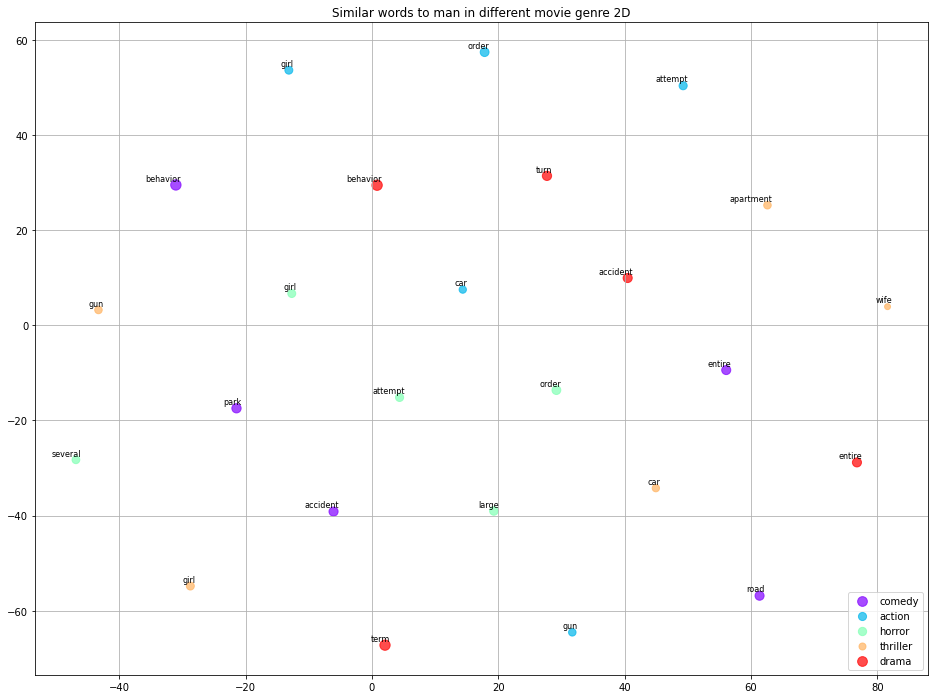

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

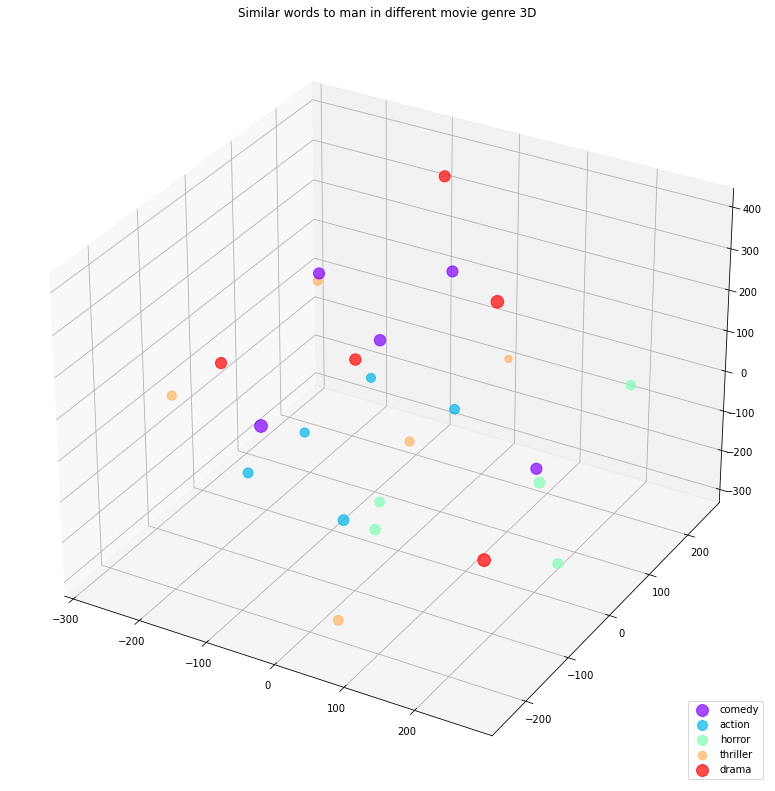

In [42]:
embedding_clusters = []
word_clusters = []
value_clusters = []
for i in range(len(data_diff_cat)):
    embeddings = []
    words = []
    values = []
    w2v_model = train_word2vec(data_diff_cat[i])
    for similar_word, value in w2v_model.wv.most_similar(most_important_word, topn=5):
        words.append(similar_word)
        values.append(value)
        embeddings.append(w2v_model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)
    value_clusters.append(values)
    
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(n_components=2, random_state=0)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

tsne_model_en_3d = TSNE(n_components=3, random_state=0)
embeddings_en_3d = np.array(tsne_model_en_3d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 3)


tsne_plot('Similar words to man in different movie genre 2D', diff_cat, embeddings_en_2d, word_clusters, np.array(value_clusters)*400, "2D")
tsne_plot('Similar words to man in different movie genre 3D', diff_cat, embeddings_en_3d, word_clusters, np.array(value_clusters)*600, "3D")

Whereas this is not directly linked to our research question of understanding how plots differ across genres, this is a graph of the which are the most similar words to the most used words plotted in 2D.

In [43]:
#Recall

print("These are the top 5 most important words: ", most_important_words)

These are the top 5 most important words:  ['family' 'life' 'love' 'father' 'man']


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

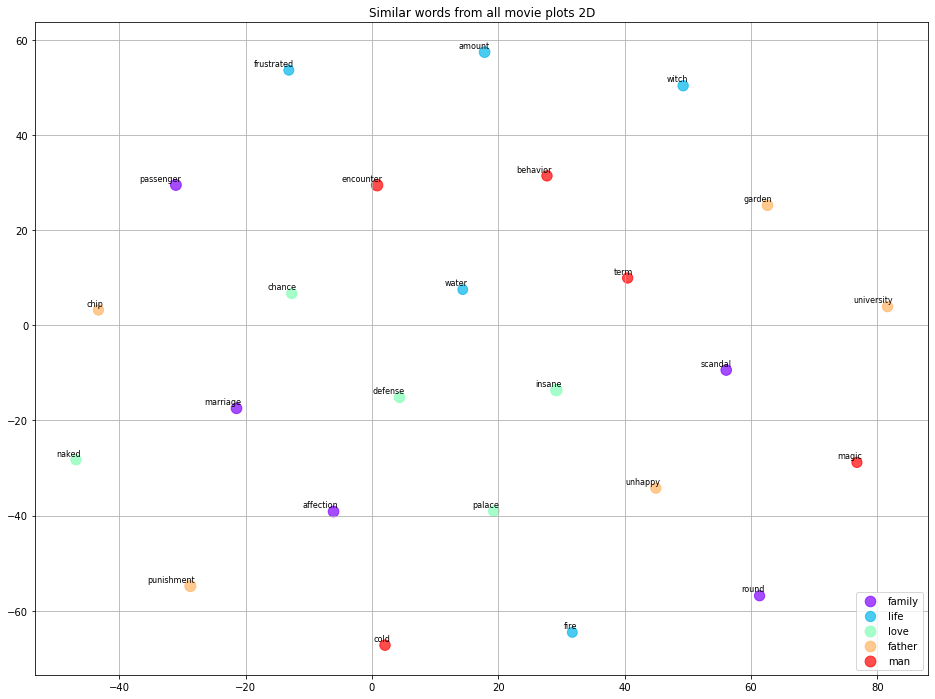

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

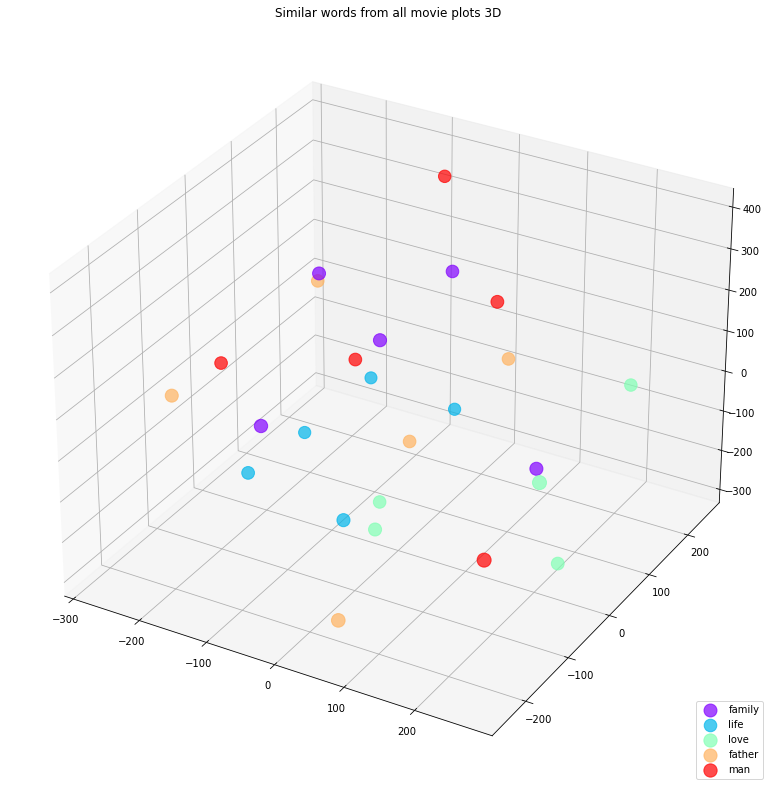

In [44]:
%matplotlib inline

w2v_model = train_word2vec(data_text)
keys = most_important_words

embedding_clusters = []
word_clusters = []
value_clusters = []
for word in keys:
    embeddings = []
    words = []
    values = []
    for similar_word, value in w2v_model.wv.most_similar(word, topn=5):
        words.append(similar_word)
        values.append(value)
        embeddings.append(w2v_model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)
    value_clusters.append(values)
    
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(n_components=2, random_state=0)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

tsne_model_en_3d = TSNE(n_components=3, random_state=0)
embeddings_en_3d = np.array(tsne_model_en_3d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 3)


tsne_plot('Similar words from all movie plots 2D', keys, embeddings_en_2d, word_clusters, np.array(value_clusters)*400, "2D")
tsne_plot('Similar words from all movie plots 3D', keys, embeddings_en_3d, word_clusters, np.array(value_clusters)*600, "3D")

<a id='doc_emb'></a>
## 2.4 Document embedding 
[Back to table of contents](#home)

Document embeddings is actually one of the most interesting subjects we can delve into as we will want to see if we can observe the different types of genres, or if on the other hand they are quite similar and on a full document it's difficult to differentiate them.

In [45]:
# With this function we will train the different documents on a doc2vec
def train_doc2vec(filename, label, verbs):
    # create a list of TaggedDocument objects
    if verbs=="yes":
        corpus = []
        count=0
        if (label=="ind"):
            for row in filename.iterrows():
                label = count
                text = row[1].processed_plots_with_verbs
                corpus.append(TaggedDocument(words=text.split(), 
                                             tags=[str(label)]))
                count+=1
        if (label=="cat"):  
            for row in filename.iterrows():
                label = row[1].Genre
                text = row[1].processed_plots_with_verbs
                corpus.append(TaggedDocument(words=text.split(), 
                                             tags=[str(label)]))
            
    if verbs=="no":   
        corpus = []
        count=0
        if (label=="ind"):
            for row in filename.iterrows():
                label = count
                text = row[1].processed_plots
                corpus.append(TaggedDocument(words=text.split(), 
                                             tags=[str(label)]))
                count+=1
        if (label=="cat"):  
            for row in filename.iterrows():
                label = row[1].Genre
                text = row[1].processed_plots
                corpus.append(TaggedDocument(words=text.split(), 
                                             tags=[str(label)]))

    # initialize model
    d2v_model = Doc2Vec(vector_size=100, 
                        window=50, #same reasoning as in word2vec
                        hs=0,
                        sample=0.0001,
                        negative=5,
                        min_count=200, #same reasoning as in word2vec 
                        workers=-1,
                        epochs=500,
                        dm=0, 
                        dbow_words=1)

    # build the vocabulary
    d2v_model.build_vocab(corpus)

    # train the model
    d2v_model.train(corpus, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)
    return d2v_model

# Helpful function when we have duplicated labels
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
    
# Plotting for doc2vec    
def plot_doc(model, title, label, dimension):
    data_doc = model.docvecs.vectors_docs
    categories = model.docvecs.index2entity
    
    if dimension=="2D":
        tsne_model_en_2d = TSNE(n_components=2, random_state=0)
        data_doc_reduced = tsne_model_en_2d.fit_transform(data_doc)
        
        print("Dimension reduction completed")
        
        fig, ax = plt.subplots(figsize = (20,14))
        
        if label=="ind":
            size = 20
            for i in range(len(data_doc_reduced[:2000])):
                x = data_doc_reduced[i][0]
                y = data_doc_reduced[i][1]
                ax.scatter(x, y, s=size, alpha=0.8, edgecolors='none', label=data_set_used['Genre'][i])
            legend_without_duplicate_labels(ax)
        elif label=="cat":
            size = 5000
            for i in range(len(data_doc_reduced)):
                x = data_doc_reduced[i][0]
                y = data_doc_reduced[i][1]
                ax.scatter(x, y, s=5000, alpha=0.8, edgecolors='none')
                ax.annotate(categories[i], alpha=1, xy=(x, y), xytext=(1, 1),
                             textcoords='offset points', ha='center', va='center', size=12)

        
    if dimension=="3D":
        tsne_model_en_3d = TSNE(n_components=3, random_state=0)
        data_doc_reduced = tsne_model_en_3d.fit_transform(data_doc)
        
        print("Dimension reduction completed")
        
        fig = plt.figure(figsize = (20,14))
        ax = fig.add_subplot(111, projection='3d')
        
        if label=="ind":
            size = 20
            for i in range(len(data_doc_reduced[:2000])):
                x = data_doc_reduced[i][0]
                y = data_doc_reduced[i][1]
                z = data_doc_reduced[i][2]
                ax.scatter(x, y, z, s=size, alpha=0.8, edgecolors='none', label=data_set_used['Genre'][i])
            legend_without_duplicate_labels(ax)
        elif label=="cat":
            size = 200
            for i in range(len(data_doc_reduced[:2000])):
                x = data_doc_reduced[i][0]
                y = data_doc_reduced[i][1]
                z = data_doc_reduced[i][2]
                ax.scatter(x, y, z, s=size, alpha=0.8, edgecolors='none', label=categories[i])
            plt.legend()
    plt.title(title)
    plt.savefig('Pictures/'+title, dpi=300)
    plt.show()

# Giving a color to each genre...
color = []
for i in range(data_set_used.shape[0]):
    genre = data_set_used['Genre'][i]
    if (genre=="action"):
        color.append("blue")
    elif (genre=="adventure"):
        color.append("black")
    elif (genre=="comedy"):
        color.append("orange")
    elif (genre=="crime"):
        color.append("red")
    elif (genre=="drama"):
        color.append("green")
    elif (genre=="horror"):
        color.append("sienna")
    elif (genre=="musical"):
        color.append("darkgrey")
    elif (genre=="romance"):
        color.append("magenta")
    elif (genre=="thriller"):
        color.append("teal")
    else:
        color.append("darkviolet")

We will only plot the first 2000 ones, plotting all of them takes a long time and results in similar results. The main takeaway is that we can't really see the difference between the plots.

### ONLY NOUN and ADJ

In [46]:
d2v_model = train_doc2vec(data_set_used, "ind", "no")

Dimension reduction completed


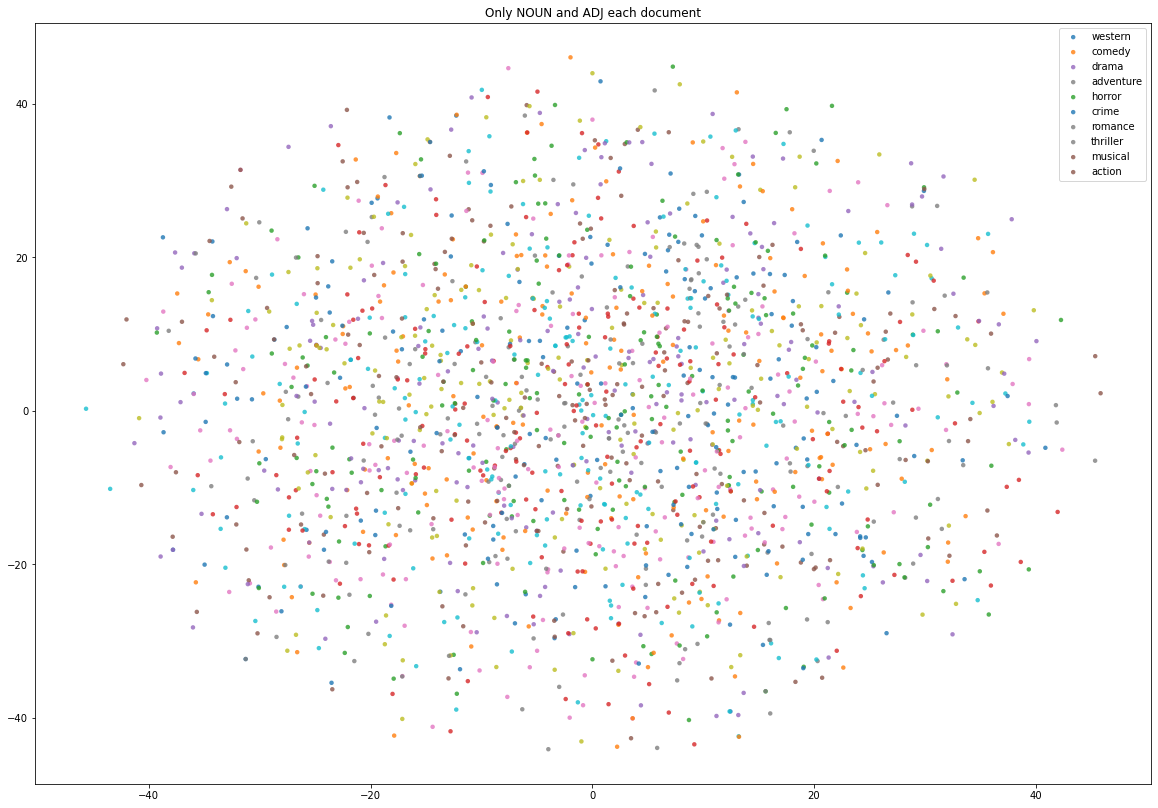

In [47]:
plot_doc(d2v_model, "Only NOUN and ADJ each document", "ind", "2D")

We will now check if we can find some pattern in 3D

Dimension reduction completed


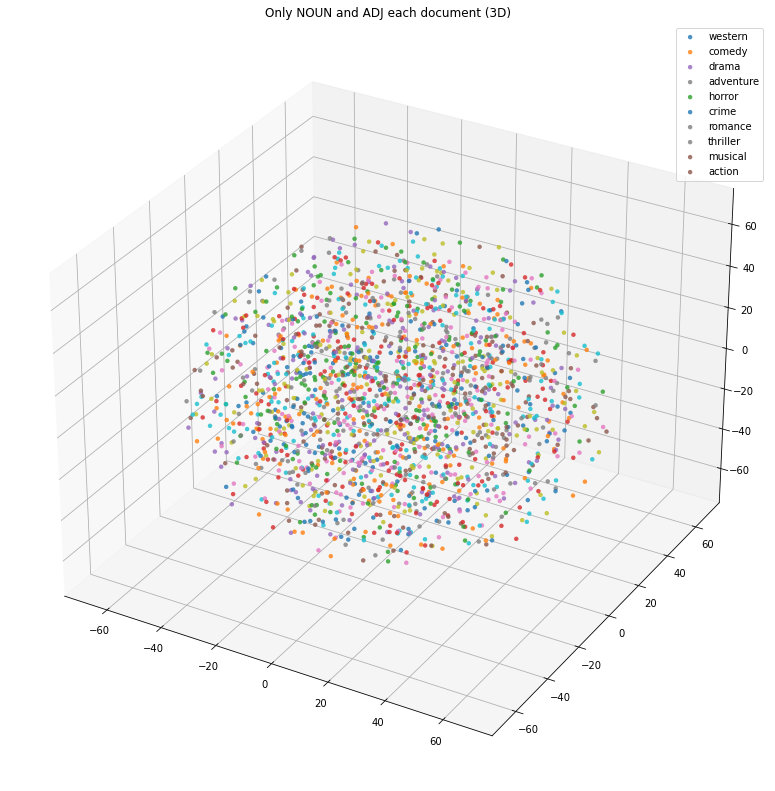

In [48]:
plot_doc(d2v_model, "Only NOUN and ADJ each document (3D)", "ind", "3D")

It would seem like the plots by genres are fundamentally the same or at least the overlaps are quite constant and too often present to see a clear distinction. If we split them by category only, then we can check the average of each category

In [49]:
d2v_model = train_doc2vec(data_set_used, "cat", "no")

In [50]:
for i in range(len(diff_cat)):
    similar_docs = d2v_model.docvecs.most_similar(diff_cat[i], topn=2)
    most_similar_words = d2v_model.wv.most_similar([d2v_model.docvecs[diff_cat[i]]], topn = 5)
    print("The most similar documents for ", diff_cat[i], " ", similar_docs)
    print("The most similar words in ", diff_cat[i], " ", most_similar_words)
    
print("Note the similarity here is calculated through cosine similarity whereas what we will observe through graphs will just be a distance in 2D or 3D")

The most similar documents for  comedy   [('romance', 0.11436092108488083), ('musical', 0.07667997479438782)]
The most similar words in  comedy   [('lifestyle', 0.31114834547042847), ('path', 0.3092097342014313), ('low', 0.3025510609149933), ('audience', 0.295897901058197), ('baby', 0.28491318225860596)]
The most similar documents for  action   [('adventure', 0.08415493369102478), ('thriller', 0.002921696752309799)]
The most similar words in  action   [('direction', 0.355866402387619), ('theater', 0.3287976384162903), ('interested', 0.32102614641189575), ('insane', 0.27887189388275146), ('guard', 0.26961785554885864)]
The most similar documents for  horror   [('adventure', 0.14230743050575256), ('romance', 0.07443338632583618)]
The most similar words in  horror   [('visit', 0.27852094173431396), ('mercenary', 0.26799294352531433), ('run', 0.2655598819255829), ('difficulty', 0.24818581342697144), ('cross', 0.245423823595047)]
The most similar documents for  thriller   [('musical', 0.142

Dimension reduction completed


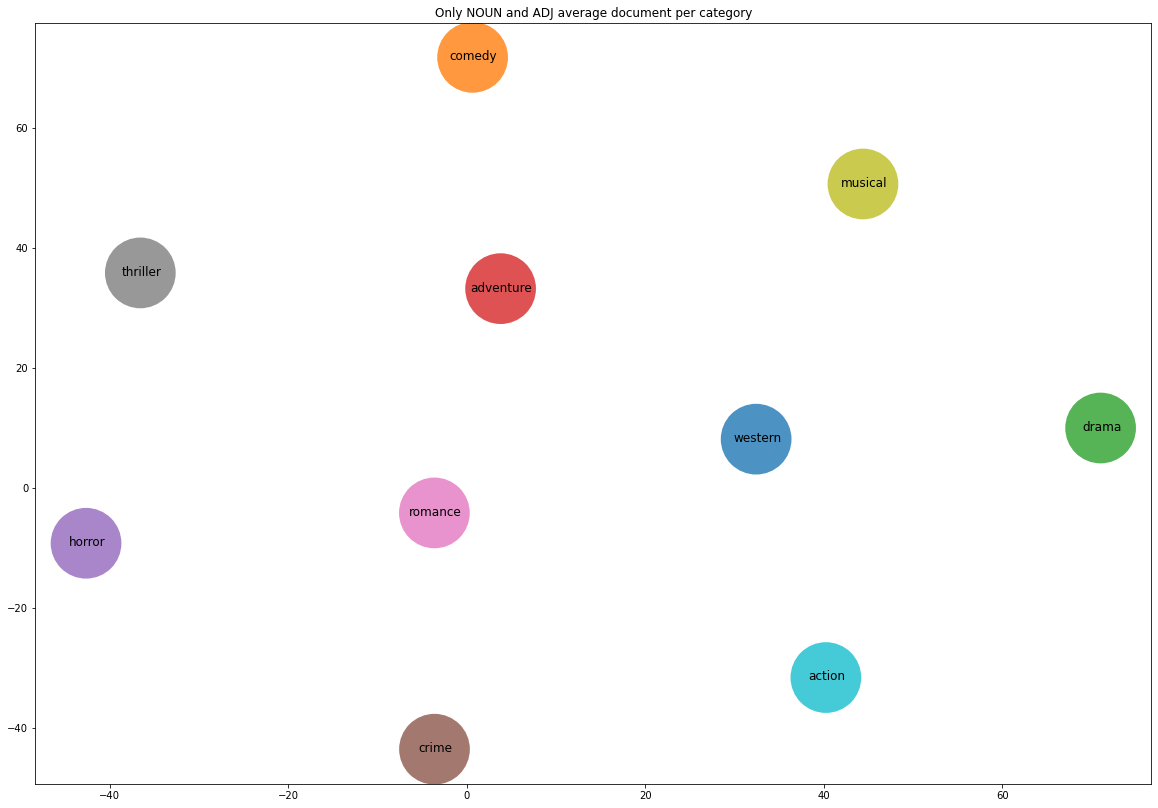

In [51]:
plot_doc(d2v_model, "Only NOUN and ADJ average document per category", "cat", "2D")

Here we can already appreciate a distinction between each genre, this shows that when aggregated there are differences but those are probably too difficult to differentiate when individually plotted.

Dimension reduction completed


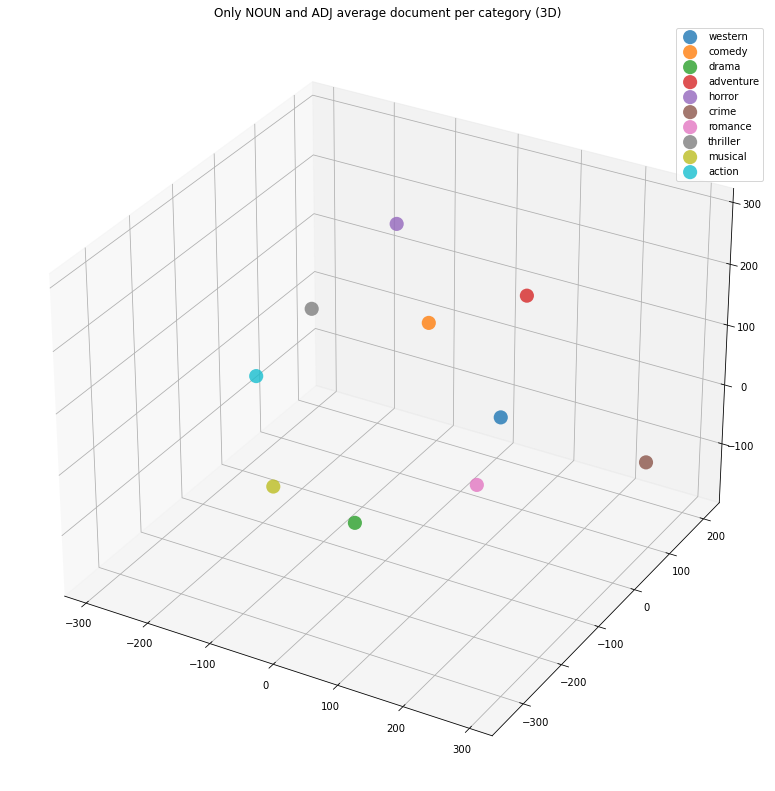

In [52]:
plot_doc(d2v_model, "Only NOUN and ADJ average document per category (3D)", "cat", "3D")

### WITH VERBS and ADVERBS

Let's now check if when we add verbs we can see a clearer difference or not

In [53]:
d2v_model = train_doc2vec(data_set_used, "ind", "yes")

Dimension reduction completed


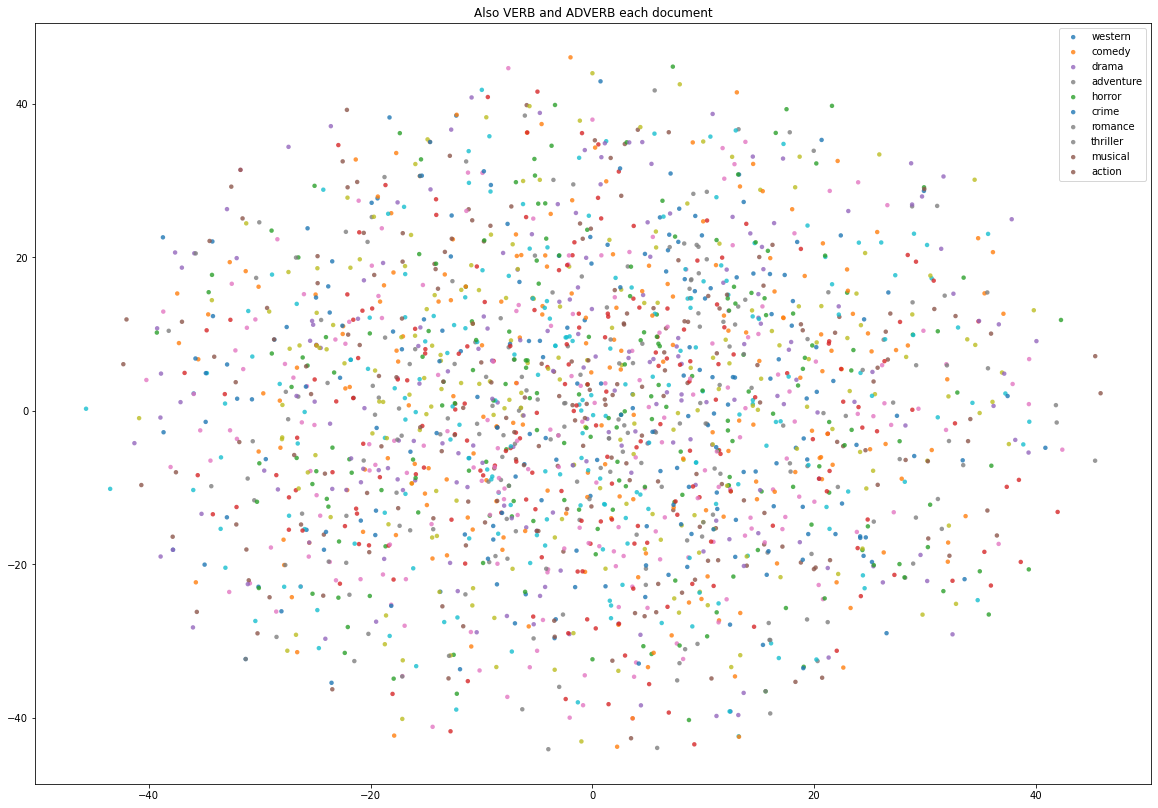

In [54]:
plot_doc(d2v_model, "Also VERB and ADVERB each document", "ind", "2D")

We will now check if we can find some pattern in 3D

Dimension reduction completed


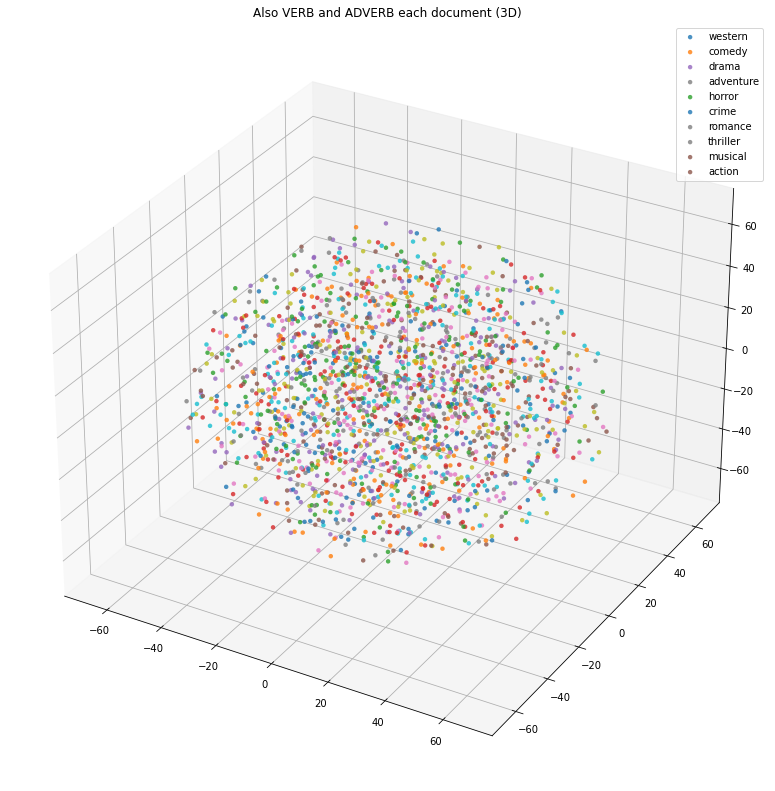

In [55]:
plot_doc(d2v_model, "Also VERB and ADVERB each document (3D)", "ind", "3D")

It would seem like the plots by genres are fundamentally the same or at least the overlaps are quite constant and too often present to see a clear distinction. If we split them by category only, then we can check the average of each category

In [56]:
d2v_model = train_doc2vec(data_set_used, "cat", "yes")

In [57]:
for i in range(len(diff_cat)):
    similar_docs = d2v_model.docvecs.most_similar(diff_cat[i], topn=2)
    most_similar_words = d2v_model.wv.most_similar([d2v_model.docvecs[diff_cat[i]]], topn = 5)
    print("The most similar documents for ", diff_cat[i], " ", similar_docs)
    print("The most similar words in ", diff_cat[i], " ", most_similar_words)
    
print("Note the similarity here is calculated through ")

The most similar documents for  comedy   [('romance', 0.11436092108488083), ('musical', 0.07667997479438782)]
The most similar words in  comedy   [('lifestyle', 0.31114834547042847), ('path', 0.3092097342014313), ('low', 0.3025510609149933), ('doubt', 0.2983788847923279), ('audience', 0.295897901058197)]
The most similar documents for  action   [('adventure', 0.08415493369102478), ('thriller', 0.002921696752309799)]
The most similar words in  action   [('direction', 0.355866402387619), ('theater', 0.3287976384162903), ('interested', 0.32102614641189575), ('testify', 0.3150426745414734), ('abduct', 0.31121528148651123)]
The most similar documents for  horror   [('adventure', 0.14230743050575256), ('romance', 0.07443338632583618)]
The most similar words in  horror   [('fast', 0.28172072768211365), ('visit', 0.27852094173431396), ('often', 0.27290141582489014), ('realise', 0.27109000086784363), ('pop', 0.26810896396636963)]
The most similar documents for  thriller   [('musical', 0.1420585

Dimension reduction completed


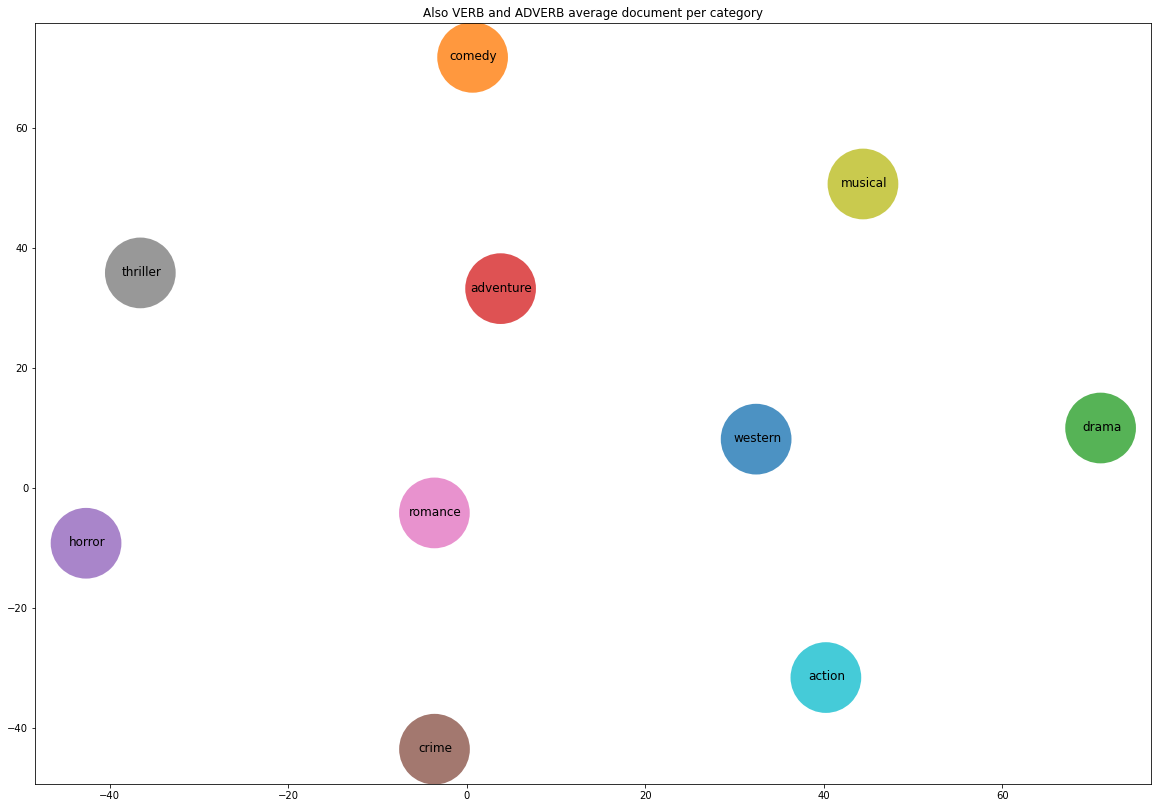

In [58]:
plot_doc(d2v_model, "Also VERB and ADVERB average document per category", "cat", "2D")

Here we can already appreciate a distinction between each genre, this shows that when aggregated there are differences but those are probably too difficult to differentiate when individually plotted.

Dimension reduction completed


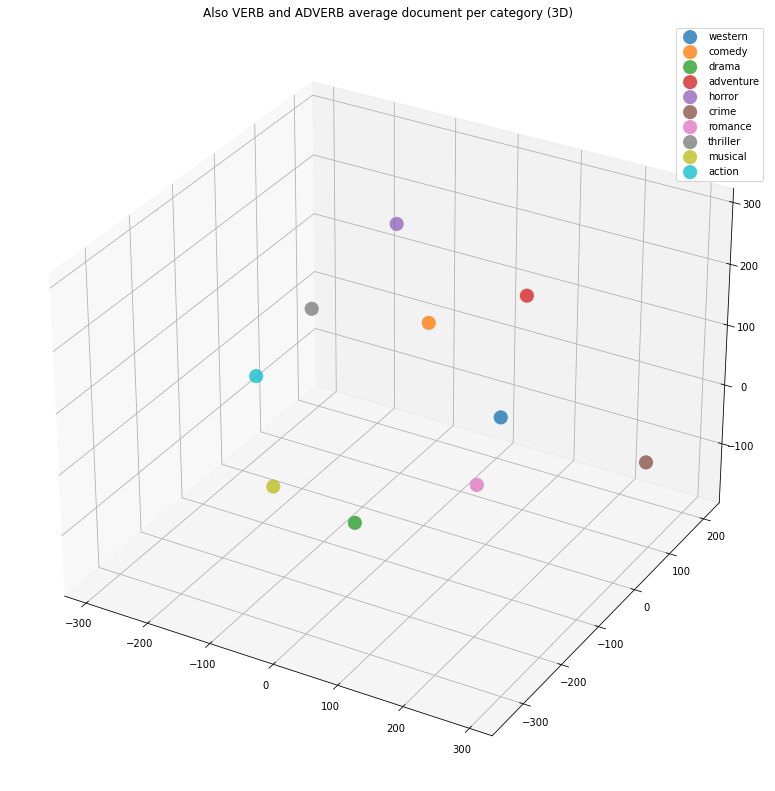

In [59]:
plot_doc(d2v_model, "Also VERB and ADVERB average document per category (3D)", "cat", "3D")

<a id='topic_models'></a>
## 2.5 Topic & Author models 
[Back to table of contents](#home)

Topic models is another one of the interesting subjects specifically for this dataset. We will try to observe how and if we can see differences between genres, if typical word vectors show up more and how/which topics show up more often in which genres. 

### ONLY NOUN and ADJ

In [60]:
target_category = 'Genre'

In [61]:
data = data_text

In [62]:
#We set up all the foundation work/inputs that we will later use in order to create the corpus
phrases = Phrases(text_to_list_list(data), min_count=50, threshold=5)
instances_colloc = phrases[text_to_list_list(data)]

dictionary = Dictionary(instances_colloc)
dictionary.filter_extremes(no_below=50, no_above=0.8)
print(dictionary, flush=True) 

ldacorpus = [dictionary.doc2bow(text) for text in text_to_list_list(data)]
tfidfmodel = TfidfModel(ldacorpus)
model_corpus = tfidfmodel[ldacorpus]

Dictionary(3300 unique tokens: ['awaken', 'bandit', 'belonging', 'box', 'car']...)


In [63]:
#We look at which number of topics would be best by evaluating using UMass and CV
coherence_values = []
for num_topics in range(2, 16):
    model = LdaMulticore(corpus=model_corpus, 
                         id2word=dictionary, 
                         num_topics=num_topics,
                         random_state=0)

    coherencemodel_umass = CoherenceModel(model=model, 
                                          texts=text_to_list_list(data), 
                                          dictionary=dictionary, 
                                          coherence='u_mass') 
    
    coherencemodel_cv = CoherenceModel(model=model, 
                                       texts=text_to_list_list(data), 
                                       dictionary=dictionary, 
                                       coherence='c_v') 

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    print(num_topics, umass_score, cv_score)
    coherence_values.append((num_topics, umass_score, cv_score))

2 -1.428969546396699 0.37002806435732527
3 -1.347443922730444 0.3894001097229771
4 -1.3287295699942199 0.3946130304457369
5 -1.3236860032938726 0.3948626152722682
6 -1.3365617090519253 0.4003368366329973
7 -1.3480697004727893 0.39719778976820075
8 -1.333122939404681 0.3896715621431915
9 -1.3108975045399778 0.39645615571678955
10 -1.3334596139788366 0.39181062243326653
11 -1.3559747500398935 0.39090137634196
12 -1.351813019651976 0.38787830759665515
13 -1.3461195596629023 0.39496928739735027
14 -1.342514439080744 0.39471316860811695
15 -1.3364540175489217 0.3887357629294393


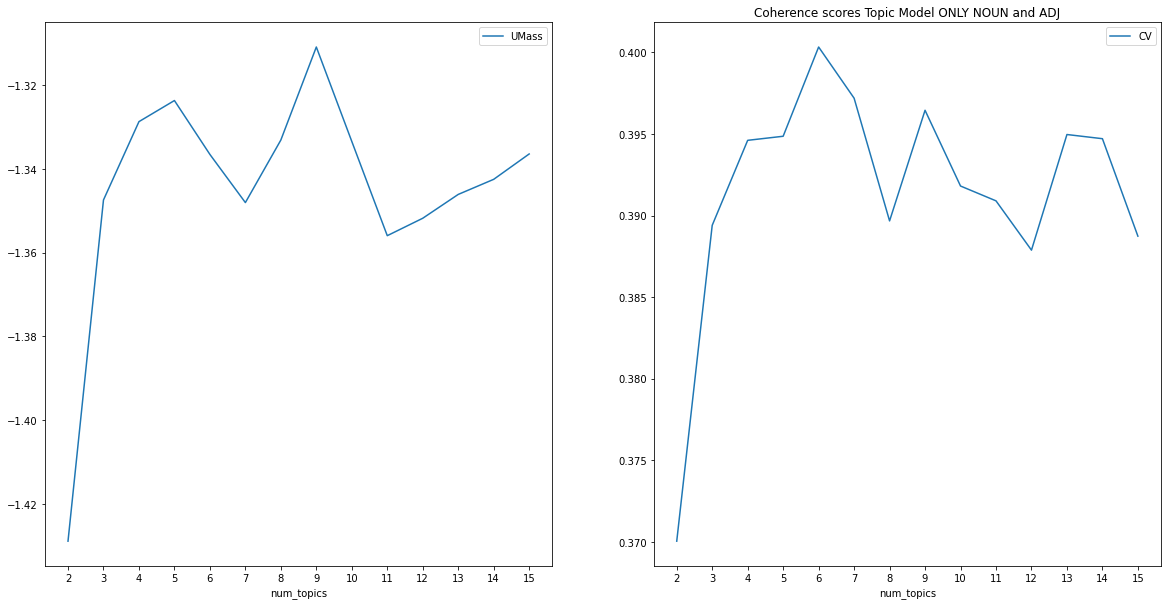

In [64]:
%matplotlib inline

scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(2,16));
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(2,16));
plt.title("Coherence scores Topic Model ONLY NOUN and ADJ")
plt.savefig('Pictures/Coherence scores Topic Model ONLY NOUN and ADJ', dpi=300)
plt.show()

We chose 9 because it had one of the highest UMass and growingly one of the highest CV

In [65]:
num_topics = 9

num_passes = 10
chunk_size = len(model_corpus) * num_passes/200
model = LdaMulticore(num_topics=num_topics, 
                     corpus=model_corpus, 
                     id2word=dictionary, 
                     passes=num_passes,
                     chunksize=chunk_size, 
                     alpha=0.5,
                     random_state=0
                    )

In [66]:
topic_corpus = model[model_corpus]
model.print_topics()

[(0,
  '0.007*"village" + 0.007*"town" + 0.006*"family" + 0.006*"man" + 0.005*"father" + 0.005*"house" + 0.005*"horse" + 0.005*"daughter" + 0.005*"wife" + 0.005*"son"'),
 (1,
  '0.006*"student" + 0.005*"professor" + 0.004*"new" + 0.004*"life" + 0.004*"love" + 0.004*"school" + 0.004*"girl" + 0.004*"thief" + 0.004*"time" + 0.003*"jewel"'),
 (2,
  '0.007*"son" + 0.006*"father" + 0.005*"gangster" + 0.005*"brother" + 0.005*"love" + 0.005*"wife" + 0.005*"family" + 0.004*"boy" + 0.004*"life" + 0.004*"daughter"'),
 (3,
  '0.005*"killer" + 0.004*"woman" + 0.004*"father" + 0.004*"man" + 0.004*"family" + 0.004*"death" + 0.004*"king" + 0.004*"detective" + 0.003*"murder" + 0.003*"case"'),
 (4,
  '0.006*"college" + 0.005*"father" + 0.005*"team" + 0.005*"husband" + 0.004*"game" + 0.004*"mother" + 0.004*"marriage" + 0.004*"friend" + 0.004*"parent" + 0.004*"job"'),
 (5,
  '0.007*"police" + 0.005*"car" + 0.004*"ship" + 0.004*"gang" + 0.004*"gun" + 0.004*"officer" + 0.004*"man" + 0.003*"money" + 0.003*"h

In [67]:
topic_sep = re.compile("0\.[0-9]{3}\*")
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) 
                for topic_no, model_topic in
                model.print_topics(num_topics=num_topics, num_words=5)]

descriptors = []
for i, m in model_topics:
    print(i+1, ", ".join(m[:5]))
    descriptors.append(", ".join(m[:2]).replace('"', ''))

1 "village", "town", "family", "man", "father"
2 "student", "professor", "new", "life", "love"
3 "son", "father", "gangster", "brother", "love"
4 "killer", "woman", "father", "man", "family"
5 "college", "father", "team", "husband", "game"
6 "police", "car", "ship", "gang", "gun"
7 "love", "story", "son", "marriage", "mother"
8 "village", "father", "island", "mother", "body"
9 "show", "family", "mother", "music", "love"


In [68]:
scores = [[t[1] for t in topic_corpus[entry]] for entry in range(num_documents)]
topic_distros = pd.DataFrame(data=scores, columns=descriptors)
topic_distros['category'] = df[target_category]
topic_distros.head()

village, town  student, professor  son, father  killer, woman  \
0       0.143851            0.077216     0.069734       0.073913   
1       0.098883            0.093021     0.103990       0.089455   
2       0.082082            0.092936     0.097655       0.086979   
3       0.245916            0.072434     0.076299       0.181281   
4       0.113790            0.081029     0.191370       0.073004   

   college, father  police, car  love, story  village, father  show, family  \
0         0.060986     0.355726     0.069340         0.086743      0.062490   
1         0.101252     0.096133     0.093954         0.090651      0.232662   
2         0.348172     0.071681     0.070601         0.079336      0.070558   
3         0.110509     0.083676     0.078229         0.076208      0.075448   
4         0.073744     0.215032     0.082535         0.096590      0.072907   

  category  
0  western  
1   comedy  
2   comedy  
3   comedy  
4    drama

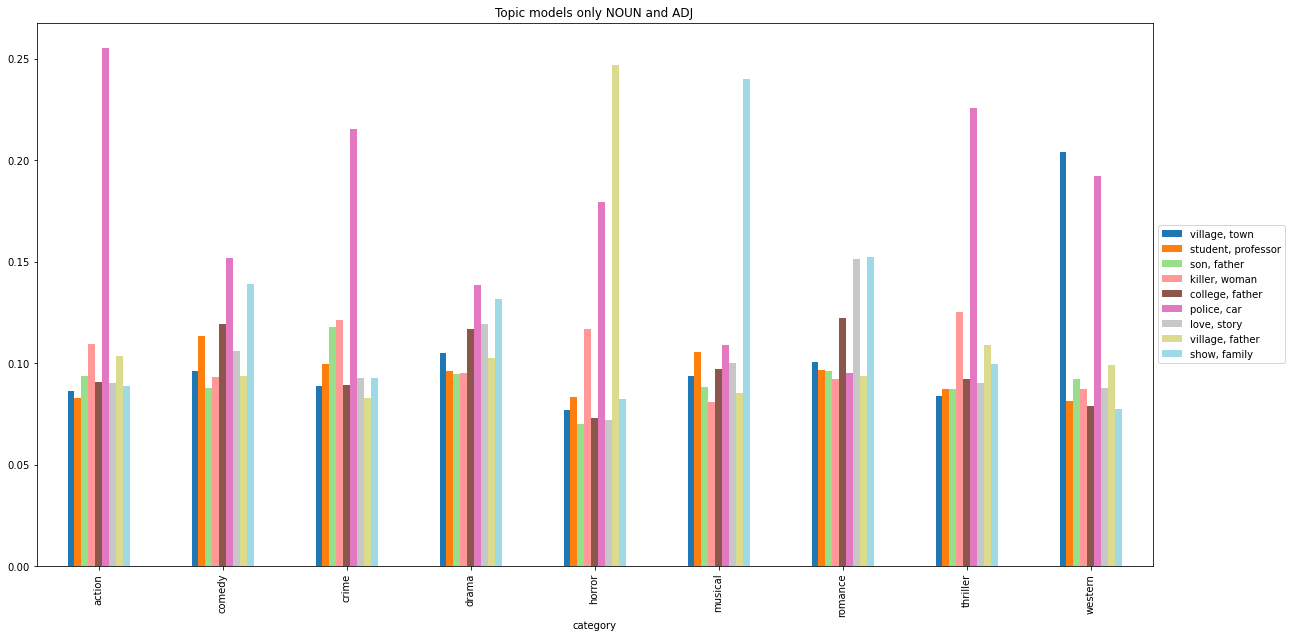

In [69]:
fig, ax = plt.subplots(figsize=(20, 10)) 

aggregate_by_category = topic_distros[topic_distros.category.isin('comedy drama thriller horror action musical romance crime western'.split())]
aggregate_by_category = aggregate_by_category.groupby(aggregate_by_category.category).mean()
aggregate_by_category[descriptors].plot.bar(ax=ax, cmap = "tab20");
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));
plt.title("Topic models only NOUN and ADJ")
plt.savefig('Pictures/Topic models only NOUN and ADJ', dpi=300)
plt.show()

Now we will use Author topic model, it helps because compared to topic models, not all the topics show up as much as in the LDA topic models, in this case we will have some topics which don't show up at all in the genres.

In [70]:
author2doc = defaultdict(list) 
for i, country in enumerate(df[target_category]):
    author2doc[country].append(i)


coherence_values = []
author_model_list = []
dev_author2doc = {key: [idx for idx in value if idx < num_documents] for key, value in author2doc.items()}
for num_topics in range(2, 16):
    author_model = AuthorTopicModel(corpus=list(ldacorpus), 
                                    author2doc=dev_author2doc, # the only difference to LDA 
                                    id2word=dictionary, 
                                    num_topics=num_topics,
                                    alpha=0.5,
                                    random_state=0
                                   )
    
    coherencemodel_umass = CoherenceModel(model=author_model, 
                                          texts=text_to_list_list(data_text), 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=author_model, 
                                       texts=text_to_list_list(data_text), 
                                       dictionary=dictionary, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    print(num_topics, umass_score, cv_score)
    coherence_values.append((num_topics, umass_score, cv_score))

2 -1.393014209593468 0.3441390331921902
3 -1.371258319160055 0.37659533988533617
4 -1.3545724620812056 0.3726113849147497
5 -1.5718276450904693 0.3753501170384804
6 -1.853895297036238 0.34931008398021185
7 -1.7628997417546268 0.3340642449327812
8 -1.8563177078438473 0.35621607980270653
9 -1.7738326674086788 0.35633030113229863
10 -1.7377229311332534 0.3632435598252711
11 -2.0967427204546474 0.3365805128185559
12 -2.1015685388077308 0.3484309794453746
13 -1.9981545672467627 0.34931124153421067
14 -2.1629052394173804 0.3586126043050898
15 -2.081503852299421 0.3540926850591147


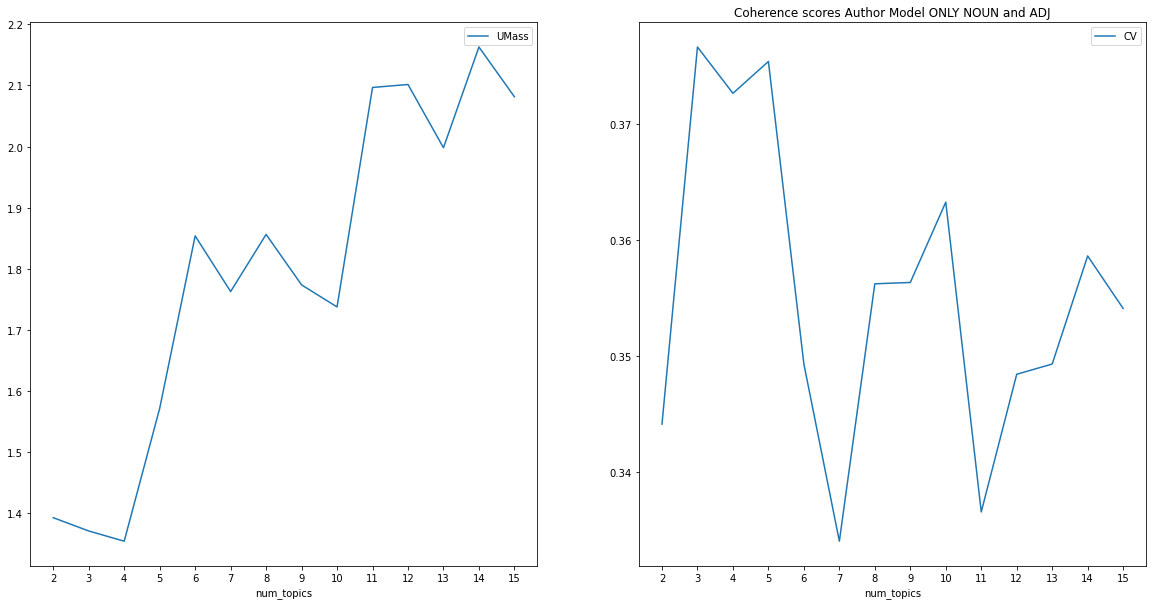

In [71]:
%matplotlib inline
scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
scores['UMass'] = -scores['UMass']
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(2,16));
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(2,16));
plt.title("Coherence scores Author Model ONLY NOUN and ADJ")
plt.savefig('Pictures/Coherence scores Author Model ONLY NOUN and ADJ', dpi=300)
plt.show()

We choose 8 because it has the best combination of UMass and CV

In [72]:
n_topics_author = 8

author_model = AuthorTopicModel(corpus=list(ldacorpus), 
                                author2doc=author2doc, 
                                id2word=dictionary, 
                                num_topics=n_topics_author,
                                passes=num_passes,
                                chunksize=chunk_size,
                                alpha=0.5,
                                random_state=0,
)

In [73]:
author_model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                author_model.print_topics(num_topics=n_topics_author, num_words=5)]

author_descriptors = []
for i, m in sorted(author_model_topics):
    print(i+1, ", ".join(m[:5]))
    author_descriptors.append(", ".join(m[:2]).replace('"', ''))
    
author_vecs = {author: {author_descriptors[t]: 0.0
                         for t in range(author_model.num_topics)}
              for author in author_model.id2author.values()
              }
for author in author_model.id2author.values():
    for (t, v) in author_model.get_author_topics(author):
        author_vecs[author][author_descriptors[t]] = v

1 "white", "body", "prosecutor", "doctor", "student"
2 "man", "town", "train", "horse", "gang"
3 "police", "car", "man", "money", "gang"
4 "friend", "new", "time", "job", "life"
5 "meat", "school", "drug", "hospital", "teacher"
6 "boat", "man", "sailor", "ship", "way"
7 "father", "family", "son", "mother", "love"
8 "house", "body", "death", "room", "dead"


In [74]:
target_countries = 'comedy drama thriller horror action musical romance crime western'.split()
for country in target_countries:
    print(country, author_vecs[country])        

comedy {'white, body': 0.017436044844821138, 'man, town': 0.03100653884646618, 'police, car': 0.07395734470043827, 'friend, new': 0.37720709568199395, 'meat, school': 0.024399903531438387, 'boat, man': 0.1205177229835823, 'father, family': 0.34886299958421696, 'house, body': 0.0}
drama {'white, body': 0.5942085156405308, 'man, town': 0.0, 'police, car': 0.02162987937875119, 'friend, new': 0.09476476382878195, 'meat, school': 0.03463812715510972, 'boat, man': 0.01372030850914096, 'father, family': 0.22054619148490198, 'house, body': 0.01583120183596839}
thriller {'white, body': 0.032485156966568667, 'man, town': 0.017806799720058396, 'police, car': 0.2931231487235538, 'friend, new': 0.19602233601072877, 'meat, school': 0.03360541149963078, 'boat, man': 0.12679610418362725, 'father, family': 0.1333953483889815, 'house, body': 0.16676569450685078}
horror {'white, body': 0.03233643173931039, 'man, town': 0.0, 'police, car': 0.05767416054299793, 'friend, new': 0.15480037302206942, 'meat, sc

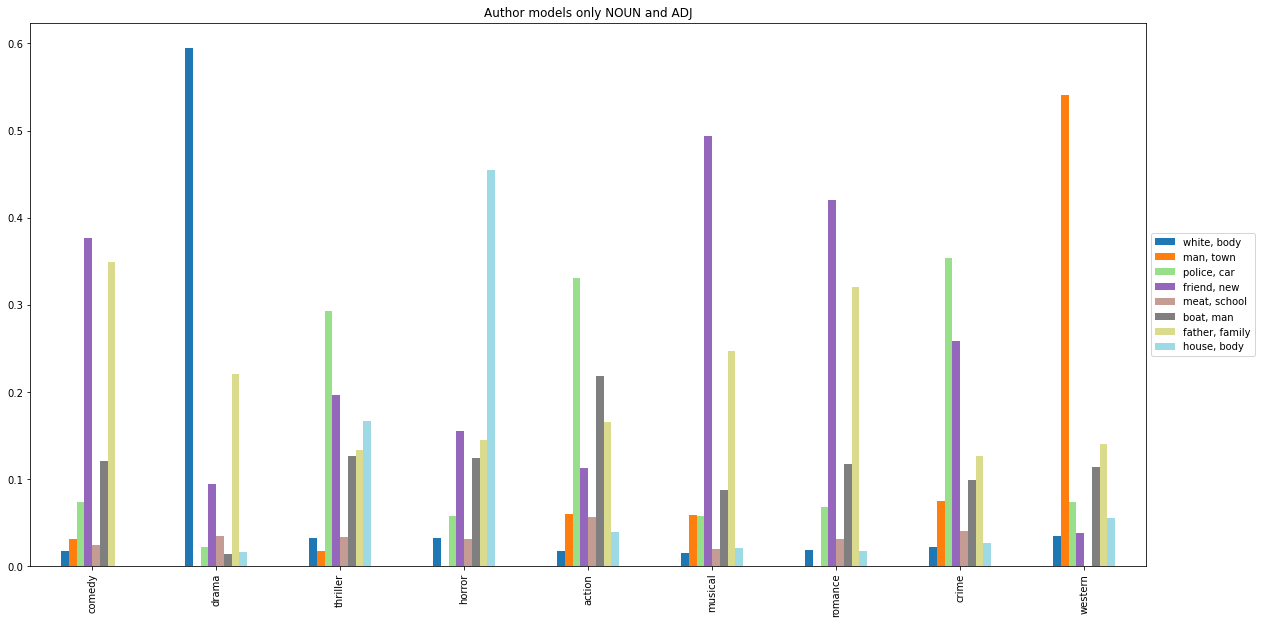

In [75]:
author_df = pd.DataFrame.from_dict(author_vecs)
fig, ax = plt.subplots(figsize=(20,10))
author_df[target_countries].T.plot.bar(ax=ax, cmap = "tab20")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));
plt.title("Author models only NOUN and ADJ")
plt.savefig('Pictures/Author models only NOUN and ADJ', dpi=300)
plt.show()

### WITH VERBS and ADVERBS

In [76]:
data = data_text_with_verbs

In [77]:
phrases = Phrases(text_to_list_list(data), min_count=70, threshold=5)
instances_colloc = phrases[text_to_list_list(data)]

dictionary = Dictionary(instances_colloc)
dictionary.filter_extremes(no_below=70, no_above=0.7)
print(dictionary, flush=True) 

ldacorpus = [dictionary.doc2bow(text) for text in text_to_list_list(data)]
tfidfmodel = TfidfModel(ldacorpus)
model_corpus = tfidfmodel[ldacorpus]

Dictionary(3712 unique tokens: ['arrive', 'awaken', 'back', 'bandit', 'belonging']...)


In [78]:
coherence_values = []
for num_topics in range(2, 16):
    model = LdaMulticore(corpus=model_corpus, 
                         id2word=dictionary, 
                         num_topics=num_topics, 
                         random_state=0)

    coherencemodel_umass = CoherenceModel(model=model, 
                                          texts=text_to_list_list(data), 
                                          dictionary=dictionary, 
                                          coherence='u_mass') 
    
    coherencemodel_cv = CoherenceModel(model=model, 
                                       texts=text_to_list_list(data), 
                                       dictionary=dictionary, 
                                       coherence='c_v') 

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    print(num_topics, umass_score, cv_score)
    coherence_values.append((num_topics, umass_score, cv_score))

2 -1.0701996022306028 0.3284311238971648
3 -1.0082953618919026 0.327357462070252
4 -1.0104404868284984 0.32780508534652764
5 -1.0146354133642226 0.3264004869934244
6 -0.9989767920700009 0.32742949673806593
7 -0.997140908001274 0.3215171884120989
8 -1.0231663440621155 0.32113256882867897
9 -0.9991305034663822 0.3243529636325111
10 -0.990685849898912 0.31881855739258314
11 -0.9880679445062267 0.32182040027408143
12 -1.048327673854603 0.3239552672647855
13 -0.9896236613455772 0.31935317026711874
14 -0.9893304009333742 0.31961704254980716
15 -1.0213923431546024 0.3216383213691276


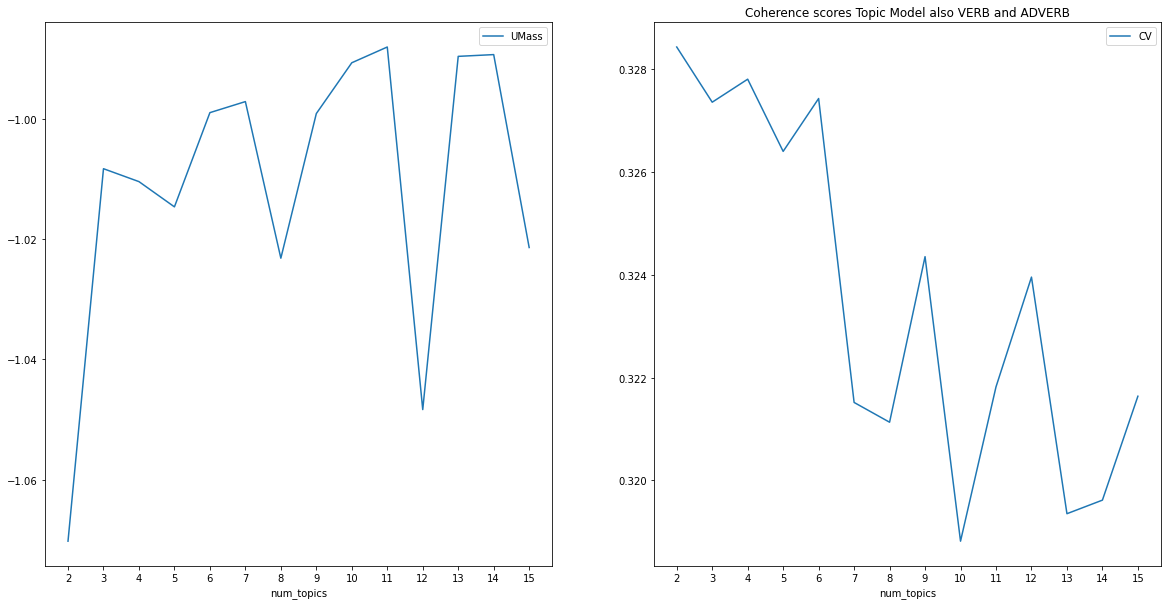

In [79]:
%matplotlib inline

scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(2,16));
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(2,16));
plt.title("Coherence scores Topic Model also VERB and ADVERB")
plt.savefig('Pictures/Coherence scores Topic Model also VERB and ADVERB', dpi=300)
plt.show()

We choose 6 because it has the best combination of UMass and CV

In [80]:
num_topics = 6

num_passes = 10
chunk_size = len(model_corpus) * num_passes/200
model = LdaMulticore(num_topics=num_topics, 
                     corpus=model_corpus, 
                     id2word=dictionary, 
                     workers=multiprocessing.cpu_count()-1, 
                     passes=num_passes, 
                     chunksize=chunk_size,
                     alpha=0.5,
                     random_state=0
                    )

In [81]:
topic_corpus = model[model_corpus]
model.print_topics()

[(0,
  '0.006*"play" + 0.005*"star" + 0.004*"band" + 0.003*"role" + 0.003*"stage" + 0.003*"show" + 0.003*"singer" + 0.003*"actor" + 0.003*"song" + 0.003*"town"'),
 (1,
  '0.004*"murder" + 0.004*"body" + 0.004*"kill" + 0.003*"find" + 0.003*"ghost" + 0.003*"house" + 0.003*"attack" + 0.003*"police" + 0.003*"investigate" + 0.003*"death"'),
 (2,
  '0.006*"ship" + 0.005*"island" + 0.004*"boat" + 0.004*"diamond" + 0.003*"woman" + 0.003*"man" + 0.003*"terrorist" + 0.003*"agent" + 0.003*"captain" + 0.003*"rescue"'),
 (3,
  '0.005*"team" + 0.004*"kill" + 0.004*"game" + 0.003*"race" + 0.003*"horse" + 0.003*"fight" + 0.003*"gang" + 0.003*"shoot" + 0.003*"man" + 0.003*"win"'),
 (4,
  '0.006*"village" + 0.005*"kill" + 0.004*"police" + 0.004*"money" + 0.004*"prison" + 0.004*"father" + 0.004*"criminal" + 0.004*"murder" + 0.003*"crime" + 0.003*"gang"'),
 (5,
  '0.005*"love" + 0.005*"family" + 0.005*"mother" + 0.004*"marry" + 0.004*"father" + 0.004*"child" + 0.004*"girl" + 0.003*"marriage" + 0.003*"tell

In [82]:
topic_sep = re.compile("0\.[0-9]{3}\*")
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) 
                for topic_no, model_topic in
                model.print_topics(num_topics=num_topics, num_words=5)]

descriptors = []
for i, m in model_topics:
    print(i+1, ", ".join(m[:5]))
    descriptors.append(", ".join(m[:2]).replace('"', ''))

1 "play", "star", "band", "role", "stage"
2 "murder", "body", "kill", "find", "ghost"
3 "ship", "island", "boat", "diamond", "woman"
4 "team", "kill", "game", "race", "horse"
5 "village", "kill", "police", "money", "prison"
6 "love", "family", "mother", "marry", "father"


In [83]:
scores = [[t[1] for t in topic_corpus[entry]] for entry in range(num_documents)]
topic_distros = pd.DataFrame(data=scores, columns=descriptors)
topic_distros['category'] = df[target_category]
topic_distros.head()

play, star  murder, body  ship, island  team, kill  village, kill  \
0    0.100163      0.211184      0.156210    0.235258       0.223053   
1    0.118398      0.108055      0.104605    0.140673       0.232557   
2    0.079238      0.094245      0.079349    0.565987       0.083208   
3    0.125015      0.242490      0.116376    0.198568       0.142133   
4    0.077194      0.116308      0.319985    0.293864       0.099569   

   love, family category  
0      0.074132  western  
1      0.295712   comedy  
2      0.097973   comedy  
3      0.175418   comedy  
4      0.093080    drama

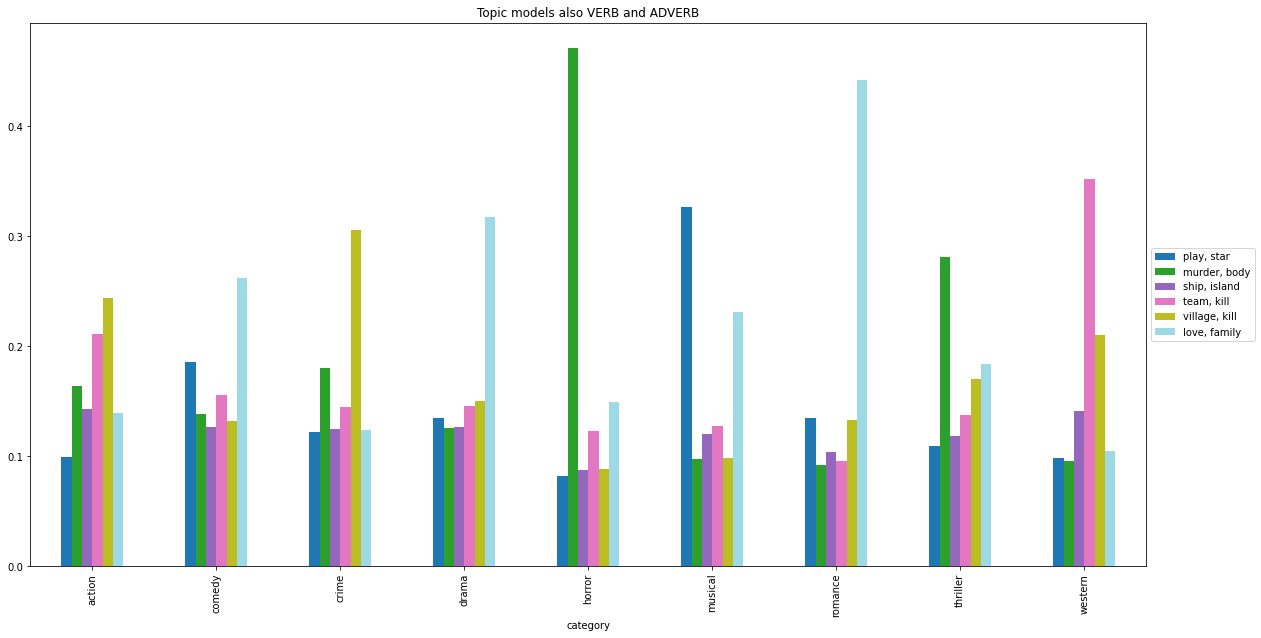

In [84]:
fig, ax = plt.subplots(figsize=(20, 10)) 

aggregate_by_category = topic_distros[topic_distros.category.isin('comedy drama thriller horror action musical romance crime western'.split())]
aggregate_by_category = aggregate_by_category.groupby(aggregate_by_category.category).mean()
aggregate_by_category[descriptors].plot.bar(ax=ax, cmap = "tab20");
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));
plt.title("Topic models also VERB and ADVERB")
plt.savefig('Pictures/Topic models also VERB and ADVERB', dpi=300)
plt.show()

Now we will use Author topic model, it helps because compared to topic models, not all the topics show up as much as in the LDA topic models, in this case we will have some topics which don't show up at all in the genres.

In [85]:
author2doc = defaultdict(list) 
for i, country in enumerate(df[target_category]):
    author2doc[country].append(i)


coherence_values = []
author_model_list = []
dev_author2doc = {key: [idx for idx in value if idx < num_documents] for key, value in author2doc.items()}
for num_topics in range(2, 16):
    author_model = AuthorTopicModel(corpus=list(ldacorpus), 
                                    author2doc=dev_author2doc, # the only difference to LDA 
                                    id2word=dictionary, 
                                    num_topics=num_topics,
                                    alpha=0.5,
                                    random_state=0
                                   )
    
    coherencemodel_umass = CoherenceModel(model=author_model, 
                                          texts=text_to_list_list(data), 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=author_model, 
                                       texts=text_to_list_list(data), 
                                       dictionary=dictionary, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    print(num_topics, umass_score, cv_score)
    coherence_values.append((num_topics, umass_score, cv_score))

2 -0.8724976063787783 0.28817495581950714
3 -0.9286469065740239 0.30055826183329304
4 -0.9652336235989099 0.30336671080889205
5 -1.044113074615442 0.29873966381501793
6 -1.0512636307852514 0.2853036783082091
7 -1.0552070893384193 0.28826910389338095
8 -1.0959893334386195 0.31329345696979993
9 -1.636945477565011 0.32820637416825593
10 -1.5892199429039675 0.34085363051401807
11 -1.544539556680337 0.3409973741457582
12 -1.5971724396509217 0.3472629495140989
13 -1.6603143722319194 0.34040791768667644
14 -1.8367549806153594 0.3341439431099654
15 -1.6439788430559716 0.3399587424634857


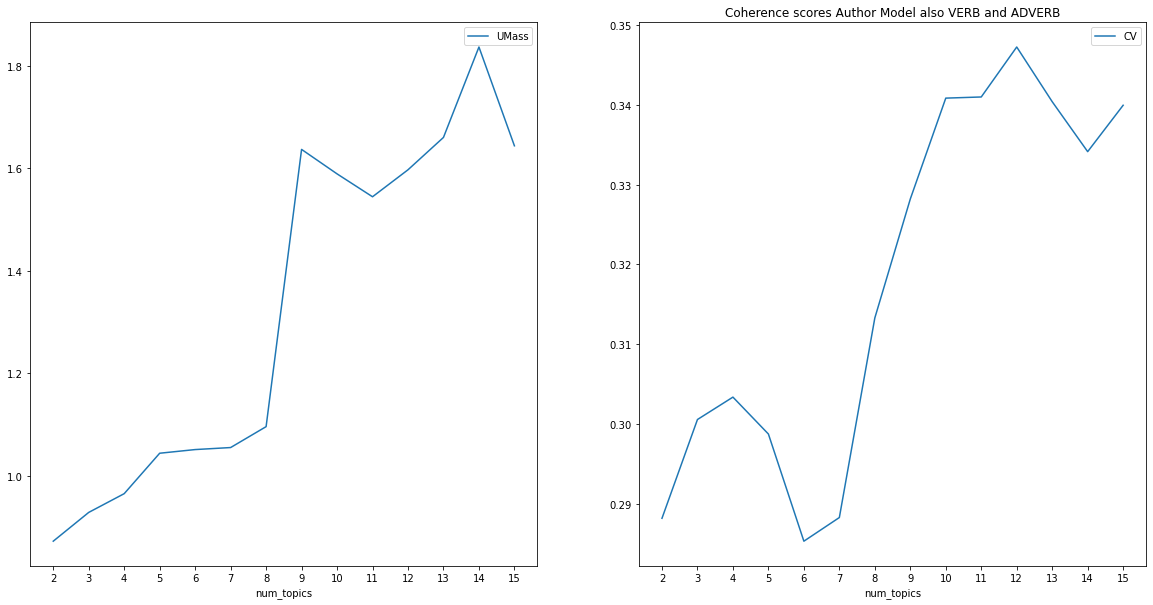

In [86]:
%matplotlib inline
scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
scores['UMass'] = -scores['UMass']
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(2,16));
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(2,16));
plt.title("Coherence scores Author Model also VERB and ADVERB")
plt.savefig('Pictures/Coherence scores Author Model also VERB and ADVERB', dpi=300)
plt.show()

We choose 14 because it has the highest UMass and good CV.

In [87]:
n_topics_author = 14

author_model = AuthorTopicModel(corpus=list(ldacorpus), 
                                author2doc=author2doc, 
                                id2word=dictionary, 
                                num_topics=n_topics_author,
                                passes=num_passes,
                                chunksize=chunk_size,
                                alpha=0.5,
                                random_state=0,
)


author_model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                author_model.print_topics(num_topics=n_topics_author, num_words=5)]

author_descriptors = []
for i, m in sorted(author_model_topics):
    print(i+1, ", ".join(m[:5]))
    author_descriptors.append(", ".join(m[:2]).replace('"', ''))
    
author_vecs = {author: {author_descriptors[t]: 0.0
                         for t in range(author_model.num_topics)}
              for author in author_model.id2author.values()
              }
for author in author_model.id2author.values():
    for (t, v) in author_model.get_author_topics(author):
        author_vecs[author][author_descriptors[t]] = v

1 "show", "play", "dance", "sailor", "actress"
2 "police", "money", "get", "plan", "arrest"
3 "boat", "return", "find", "ship", "island"
4 "car", "run", "group", "back", "sex"
5 "kill", "man", "take", "village", "brother"
6 "father", "family", "love", "come", "take"
7 "kill", "find", "house", "body", "murder"
8 "get", "find", "make", "try", "decide"
9 "white", "body", "discuss", "bury", "say"
10 "doctor", "mother", "son", "death", "hospital"
11 "man", "town", "shoot", "kill", "gun"
12 "tell", "leave", "take", "find", "man"
13 "meat", "drug", "central", "trunk", "location"
14 "win", "local", "support", "election", "dad"


In [88]:
target_countries = 'comedy drama thriller horror action musical romance crime western'.split()
for country in target_countries:
    print(country, author_vecs[country])        

comedy {'show, play': 0.08319427604808617, 'police, money': 0.026810173377527804, 'boat, return': 0.04563890323545004, 'car, run': 0.01965326004939084, 'kill, man': 0.06475255265343165, 'father, family': 0.46911429763611495, 'kill, find': 0.0, 'get, find': 0.09184715832724397, 'white, body': 0.0, 'doctor, mother': 0.015352534855803603, 'man, town': 0.0, 'tell, leave': 0.15311301555329881, 'meat, drug': 0.0, 'win, local': 0.0}
drama {'show, play': 0.0, 'police, money': 0.0, 'boat, return': 0.0, 'car, run': 0.03958870063776915, 'kill, man': 0.01765850484697376, 'father, family': 0.2332487338440279, 'kill, find': 0.0, 'get, find': 0.0, 'white, body': 0.3793214353589309, 'doctor, mother': 0.18692741665584, 'man, town': 0.0, 'tell, leave': 0.09644377633809836, 'meat, drug': 0.02148290408046129, 'win, local': 0.0}
thriller {'show, play': 0.01011535473897, 'police, money': 0.03946875906120162, 'boat, return': 0.03628879616537921, 'car, run': 0.11063183866801819, 'kill, man': 0.106687211383975

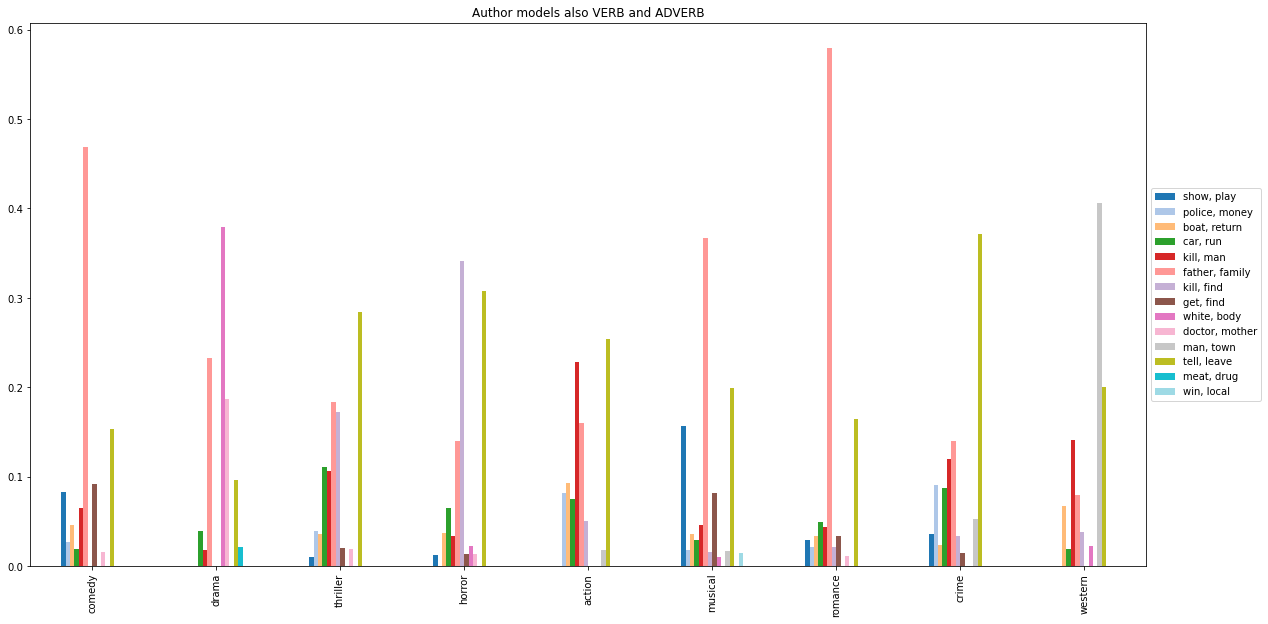

In [89]:
author_df = pd.DataFrame.from_dict(author_vecs)
fig, ax = plt.subplots(figsize=(20,10))
author_df[target_countries].T.plot.bar(ax=ax, cmap = "tab20")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));
plt.title("Author models also VERB and ADVERB")
plt.savefig('Pictures/Author models also VERB and ADVERB', dpi=300)
plt.show()

In general we can notice that we get rather similar results, with or without verbs, the nice addition when we have verbs is that they bring words such as "kill" which fit very well to some plots. Hence, this is quite an intersting finding. Overall this seems to be some of the best way of differentiating each genre.

<a id='lang_models'></a>
## 2.6 Language models 
[Back to table of contents](#home)

Language models use the full text without any cleaning, it will be intersting to see what kind of story plots we get from each category, if one can tell just by looking at the plots. It's highly encouraged to look only at the plot at first and then try to guess which genre it was.

In [90]:
#This is the function that we use to generate random sentences given the data input
def create_sentence_structure(text):
    all_list = text_to_list_list(text)
    smoothing = 0.001 #this is for words we haven't seen yet and we don't want our model to be 0 just because we haven't seen the word yet... so we just say "we've seen it before..."
    START = '_***_'
    STOP = '_STOP_'
    counts = defaultdict(lambda: defaultdict(lambda: smoothing)) #so basically we add the word to a dictionnary and if it's not in their we used smoothing as the values...
    for sentence in all_list:
        tokens = [START, START] + sentence + [STOP]
        for u, v, w in nltk.ngrams(tokens, 3):
            counts[(u, v)][w] += 1
            
    def logP(u, v, w):
        """
        compute the log probability of a trigram
        (u,v,w) => P(w|u,v) = c(u,v,w) / SUM(c(u,v,*))
        """
        return np.log(counts[(u, v)][w]) - np.log(sum(counts[(u, v)].values()))

    def sentence_logP(S):
        """
        score a sentence in log likelihood with chain rule
        S: list(str)
        """
        tokens = [START, START] + S + [STOP]
        print(tokens)
        return sum([logP(u, v, w) for u, v, w in nltk.ngrams(tokens, 3)])

    def generate():
        """
        generate a new sentence
        """
        result = [START, START]
        next_word = sample_next_word(result[-2], result[-1])
        result.append(next_word)
        while next_word != STOP:
            next_word = sample_next_word(result[-2], result[-1])
            result.append(next_word)

        return ' '.join(result[2:-1])

    def sample_next_word(u, v):
        """
        sample a word w based on the history (u, v)
        """
        keys, values = zip(*counts[(u, v)].items())
        values = np.array(values)
        values /= values.sum() 
        sample = np.random.multinomial(1, values) 
        return keys[np.argmax(sample)]

    return generate()



In [91]:
all_text = data_set_used["Plot"].to_list()

text_diff_cat = [text_comedy, text_action, text_horror, text_thriller, text_drama]

for i in range(len(text_diff_cat)):  
    print(create_sentence_structure(text_diff_cat[i]), "\n")
    time.sleep(10)
    print("This was generated from the following genre: ", diff_cat[i], ". \n \n")
    

print("This is a plot generate from: any random movie \n", create_sentence_structure(all_text), "\n")

In Bedrock, Slate International's new CEO Cliff Vandercave and secretary Miss Jones. One morning the family company, has learned of Iris's shady character, Breezy goes back to Miami, Florida where they jump to the money. His uncle imposes an odious requirement of him: Alby will receive a broadcast showing human females. They are so senselessly obsessed with Abraham Lincoln, creates a muck-slide that nearly kills Jim Ryan (Fred MacMurray), the cocky well-built sandhog they call the man of the film, which turns out to be Carol's long-lost first husband, Roy Martin, shows up to trouble, mostly by scamming people. On the final round of drinks for six months later, Jackie interviews Becket, and asks what he thought he was, and when Mike finds out that Teddy is the local meatworks. This leaves him and take care of their furniture. 

This was generated from the following genre:  comedy . 
 

El Mariachi to allow him to her sing a beautiful girl Nandu (Hansika Motwani), daughter of a gang, a S

Now let's check how closely it relates so some of the statistics we observed before...

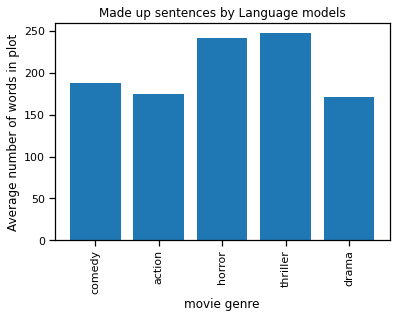

In [92]:
num_plots_made = 100
lang_model_comedy = []
lang_model_action = []
lang_model_horror = []
lang_model_thriller = []
lang_model_drama = []
num_words = []
lang_model_cat = [lang_model_comedy, lang_model_action, lang_model_horror, lang_model_thriller, lang_model_drama]

for i in range(len(text_diff_cat)):   
    for j in range(num_plots_made):
        lang_model_cat[i].append(create_sentence_structure(text_diff_cat[i]))
    num_words.append(sum(vectorizer.fit_transform(lang_model_cat[i]).sum(axis=0).A1))    
    
sb.set_context('notebook')
making_bar_chart(np.array(num_words)/num_plots_made, diff_cat, 'movie genre', 'Average number of words in plot', 'Made up sentences by Language models')

<a id='lat_dim'></a>
## 2.7 Latent dimensions 
[Back to table of contents](#home)

Here we will want to see if we can reduce the data in different ways, more specifically to later plot it. This is a very similar approach to doc2vec, the aim is to try to understand if we can see a difference between each genre when plotted document specific.

In [93]:
def show_topics(A, vocabulary, topn=5):
    """
    find the top N words for each of the latent dimensions (=rows) in a matrix
    """
    topic_words = ([[vocabulary[i] for i in np.argsort(t)[:-topn-1:-1]]
                    for t in A])
    return [', '.join(t) for t in topic_words]

sb.set_context('notebook')
def plot_vectors(vectors, title='VIZ', labels=None, dimensions=3):
    """
    plot the vectors in 2 or 3 dimensions. 
    If labels are supplied, use them to color the data accordingly
    """
    # set up graph
    fig = plt.figure(figsize=(10,10))

    # create data frame
    df = pd.DataFrame(data={'x':vectors[:,0], 'y': vectors[:,1]})
    # add labels, if supplied
    if labels is not None:
        df['label'] = labels
    else:
        df['label'] = [''] * len(df)

    # assign colors to labels
    cm = plt.get_cmap('tab20') # choose the color palette
    n_labels = len(df.label.unique())
    label_colors = [cm(1. * i/n_labels) for i in range(n_labels)]
    cMap = colors.ListedColormap(label_colors)
        
    # plot in 3 dimensions
    if dimensions == 3:
        # add z-axis information
        df['z'] = vectors[:,2]
        # define plot
        ax = fig.add_subplot(111, projection='3d')
        frame1 = plt.gca() 
        # remove axis ticks
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        frame1.axes.zaxis.set_ticklabels([])

        # plot each label as scatter plot in its own color
        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], df2['z'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor='black', 
                       label=label, 
                       alpha=0.8, 
                       s=100)
      
    # plot in 2 dimensions
    elif dimensions == 2:
        ax = fig.add_subplot(111)
        frame1 = plt.gca() 
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])

        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor='black', 
                       label=label, 
                       alpha=0.8, 
                       s=100)

    else:
        raise NotImplementedError()

    plt.title(title)
    plt.legend()
    plt.savefig('Pictures/'+title, dpi=300)
    plt.show()

In [94]:
#We get all the words that are used and set some and count them according to tfidf, this will give us an understanding of which words have the most importance
all_text = data_set_used["processed_plots"].to_list()
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), 
                                   analyzer='word', 
                                   min_df=0.001, 
                                   max_df=0.75, 
                                   sublinear_tf=True, 
                                   use_idf=True)

X = tfidf_vectorizer.fit_transform(all_text)
terms = tfidf_vectorizer.get_feature_names()

We will choose 9 different topis like we had in topic models

In [95]:
k = 9

svd = TruncatedSVD(n_components=k)
U = svd.fit_transform(X)
S = svd.singular_values_
V = svd.components_

nmf = NMF(n_components=k, init='nndsvd', random_state=0)
W = nmf.fit_transform(X)
H = nmf.components_

Here we will compare the difference that we have in the topics between SVD and NMF.

In [96]:
print("There are the topics for SVD: \n", show_topics(V, terms))

There are the topics for SVD: 
 ['man, father, life, love, family', 'love, family, marriage, father, mother', 'son, brother, man, gang, village', 'mother, house, body, family, child', 'ship, island, soldier, group, village', 'wife, husband, woman, man, affair', 'story, love, police, murder, village', 'girl, love, man, young, woman', 'young, life, story, murder, son']


In [97]:
print("There are the topics for NMF: \n", show_topics(H, terms))

There are the topics for NMF: 
 ['house, car, body, room, dead', 'police, murder, crime, gang, criminal', 'family, father, son, mother, daughter', 'job, money, show, new, star', 'ship, soldier, war, island, officer', 'wife, husband, woman, affair, married', 'love, story, girl, marriage, life', 'town, horse, man, sheriff, ranch', 'school, student, teacher, college, class']


In [98]:
Z = X.copy()
categories = df1.Genre

Now we will put it in 2 and 3 dimensions in order to plot it, like this we will be able to graph the observed results.

In [99]:
low_dim_svd_2 = TruncatedSVD(n_components=2)
low_dim_nmf_2 = NMF(n_components=2, init='nndsvd')

low_dim_U_2 = low_dim_svd_2.fit_transform(Z)
low_dim_W_2 = low_dim_nmf_2.fit_transform(Z)

plot_sample = np.random.choice(Z.shape[0], replace=False, size=500)

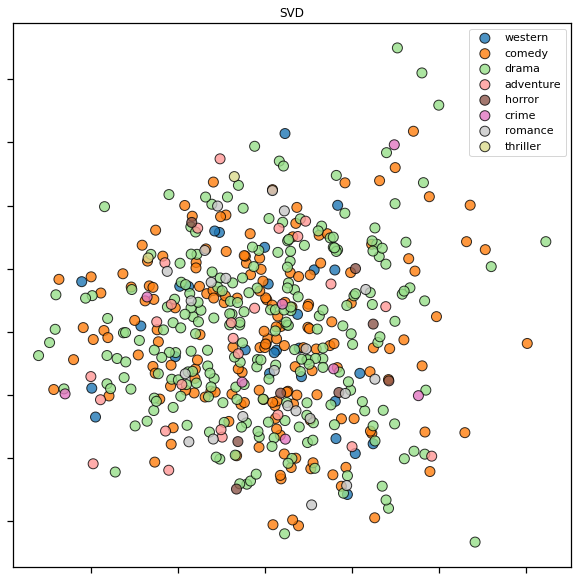

In [100]:
plot_vectors(low_dim_U_2[plot_sample], title='SVD', labels=categories, dimensions=2)

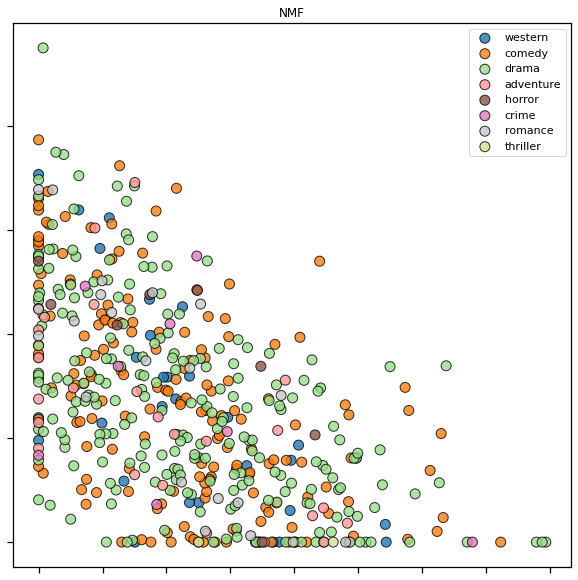

In [101]:
plot_vectors(low_dim_W_2[plot_sample], title='NMF', labels=categories, dimensions=2)

In [102]:
low_dim_svd_3 = TruncatedSVD(n_components=3)
low_dim_nmf_3 = NMF(n_components=3, init='nndsvd')

low_dim_U_3 = low_dim_svd_3.fit_transform(Z)
low_dim_W_3 = low_dim_nmf_3.fit_transform(Z)

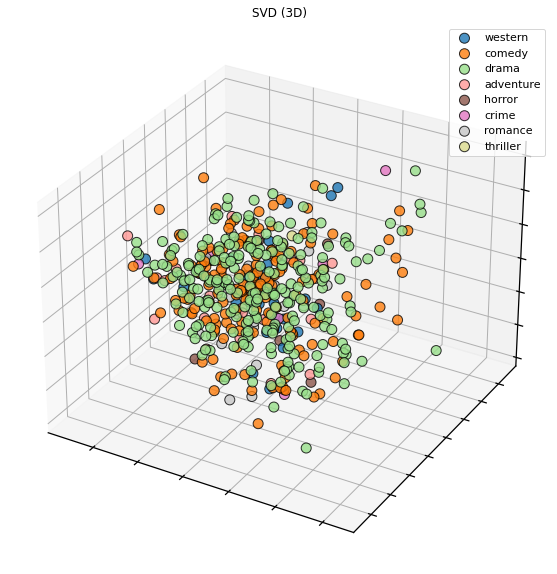

In [103]:
plot_vectors(low_dim_U_3[plot_sample], title='SVD (3D)', labels=categories, dimensions=3)

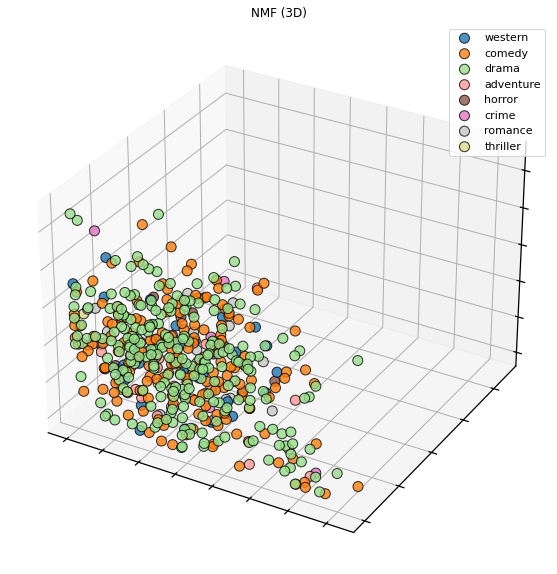

In [104]:
plot_vectors(low_dim_W_3[plot_sample], title='NMF (3D)', labels=categories, dimensions=3)

<a id='clustering'></a>
## 2.8 Clustering
[Back to table of contents](#home)

Since we already have genres, we will only take clustering algorithms where you can set the cluster size, hence allowing us to compare how well the algorithms are clustering the data. This would enable us to see if there are significant differences between the genres. Additionally, in order to set the cluster size, most algorithms require even clusters, so we will sample evenly from each genre 200 observations.

In [105]:
only_top_5 = data_set_used[((data_set_used['Genre']=="comedy")|(data_set_used['Genre']=="horror")|(data_set_used['Genre']=="drama")|(data_set_used['Genre']=="action")|(data_set_used['Genre']=="thriller"))].reset_index().drop(['index'],axis=1)
all_text = only_top_5['processed_plots'].to_list()

In [106]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), 
                                   analyzer='word', 
                                   min_df=0.001, 
                                   max_df=0.75, 
                                   sublinear_tf=True, 
                                   use_idf=True)

X = tfidf_vectorizer.fit_transform(all_text)
terms = tfidf_vectorizer.get_feature_names()
X2 = TruncatedSVD(n_components=300).fit_transform(X) #we initially reduce dimensions for computational purposes (from 9507 to 300)

This silouettes score is more to check if it's really wrong to use 5 clusters...

2 0.007184827233285817
3 0.001996602261034147
4 0.001457068020150597
5 0.0028276319261860768
6 0.0001401199488179928
7 0.0002064461246609756
8 -0.0008035573524837016
9 -0.0005602580644710407
10 -0.0005117343059322122
11 0.0006732028994448498
12 0.0009263772029019008
13 0.0006606952552254206
14 0.0012100417484125115


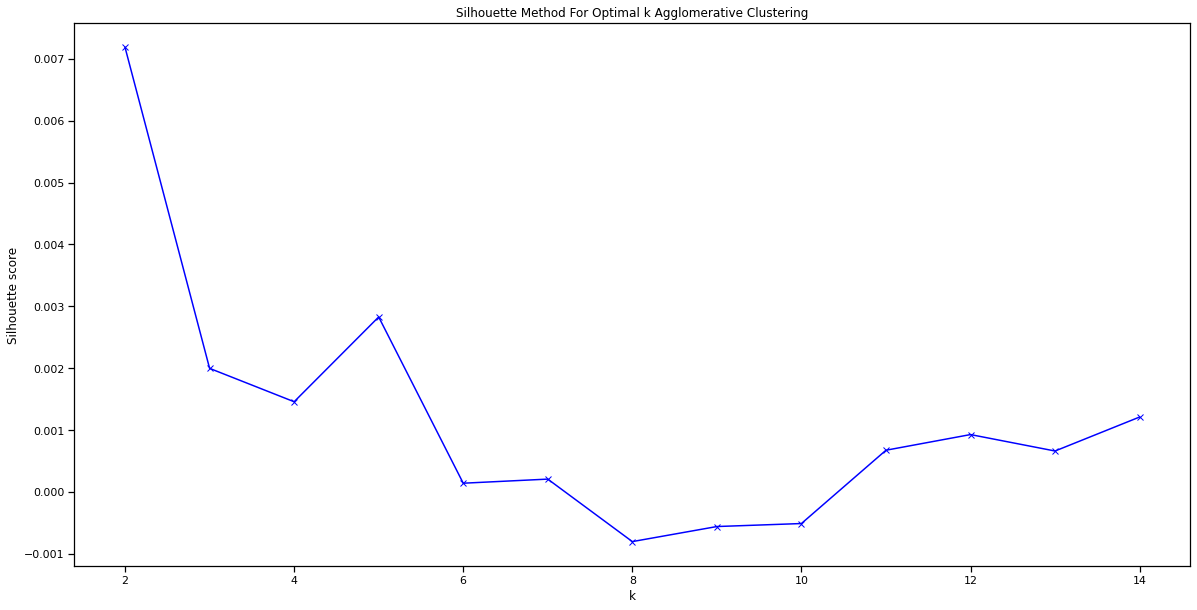

<Figure size 432x288 with 0 Axes>

In [107]:
silhouettes = []

K = range(2, 15)

for c in K:
    agg_clustering = AgglomerativeClustering(n_clusters=c)
    agg_cluster_ids = agg_clustering.fit_predict(X2)
    score = silhouette_score(X2, agg_cluster_ids)
    silhouettes.append(score)
    print(c, score)
    
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method For Optimal k Agglomerative Clustering')
plt.show()
plt.savefig('Pictures/Silhouette Method For Optimal k Agglomerative Clustering', dpi=300)

What we can observe from the silouhette score is that it does not seem like clusters are easy distinctive. We will nevertheless choose 5 clusters as this seems to have a slight increase as oppose to 4 and makes more sense given our data.

In [108]:
k = 5
agg = AgglomerativeClustering(n_clusters=k)

def random_sample_equal_size_per_cat(size):
    replace = False  # with replacement
    fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
    sample = np.array(only_top_5.groupby('Genre', as_index=False).apply(fn).reset_index().drop(['level_0'], axis=1)['level_1'])
    
    return sample

sample = random_sample_equal_size_per_cat(200)
# sample = np.random.choice(len(X2), replace=False, size=800)
agg_sample_ids = agg.fit_predict(X2[sample])
genres = np.array(only_top_5['Genre'][sample])

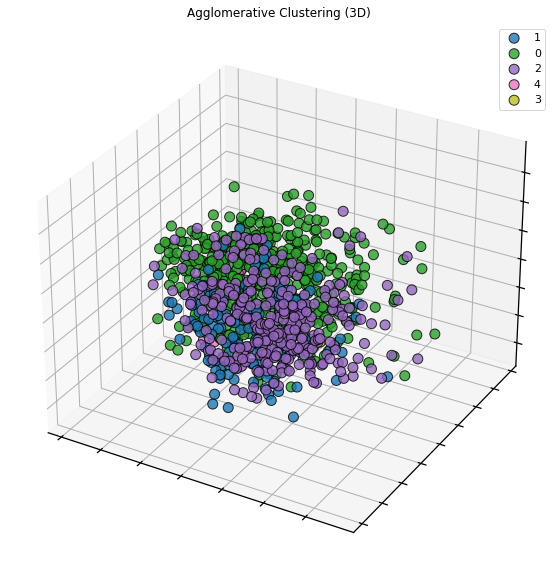

In [109]:
plot_vectors(X2[sample], "Agglomerative Clustering (3D)", labels=agg_sample_ids)

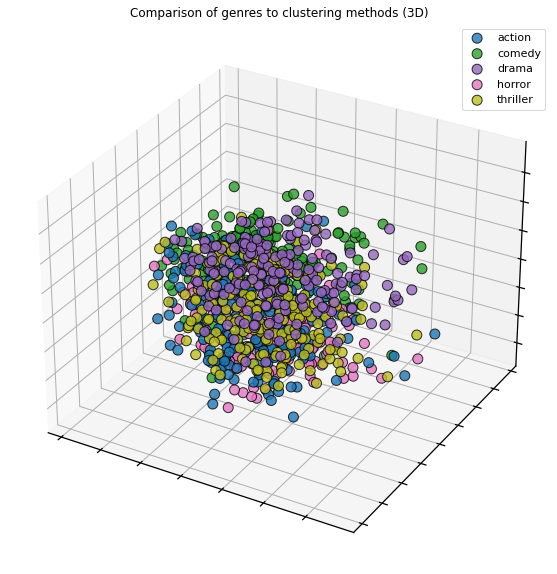

In [110]:
plot_vectors(X2[sample], "Comparison of genres to clustering methods (3D)", labels=genres)

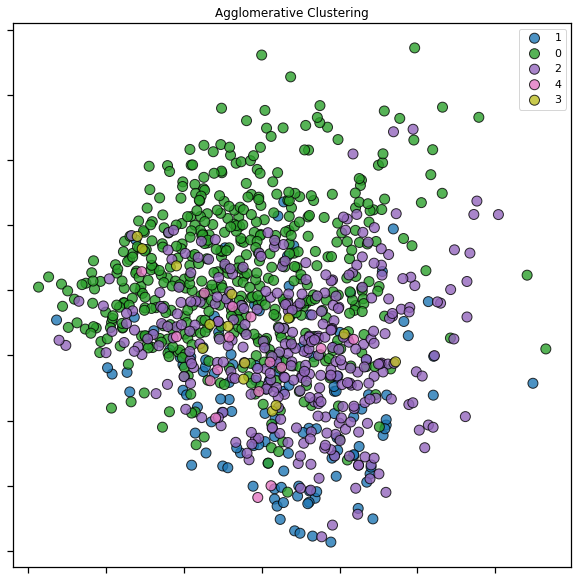

In [111]:
plot_vectors(X2[sample], "Agglomerative Clustering", labels=agg_sample_ids, dimensions=2)

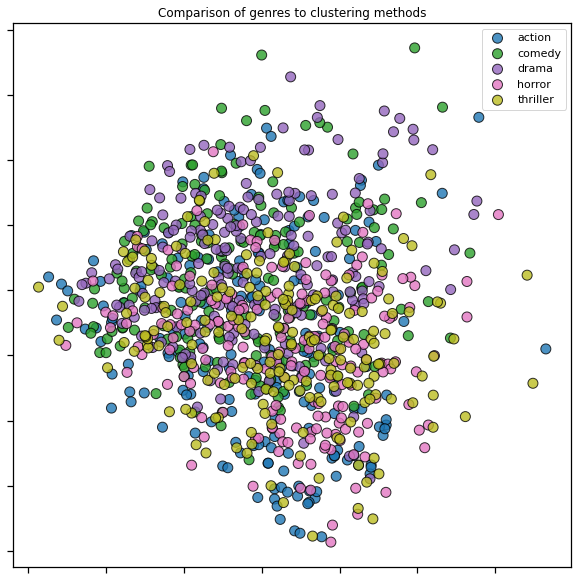

In [112]:
plot_vectors(X2[sample], "Comparison of genres to clustering methods", labels=genres, dimensions=2)

### Spectral Clustering

Chose spectral clustering because you can choose the number of clusters and it's for medium sample size and small number of clusters.

In [113]:
spc = SpectralClustering(n_clusters=5, n_jobs=-1, random_state=0)
spc_sample_ids = spc.fit_predict(X2[sample])

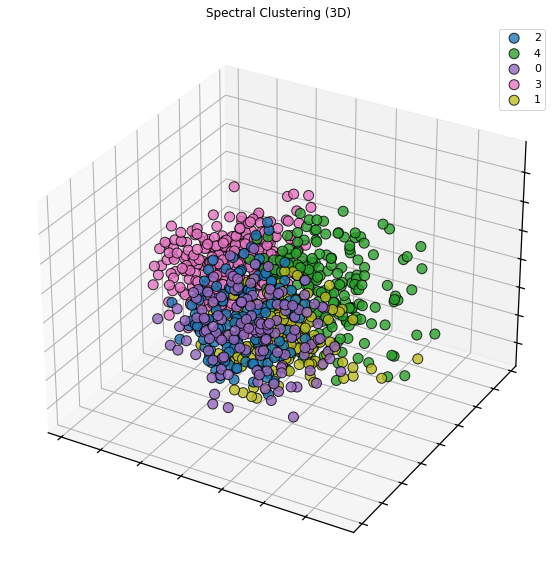

In [114]:
plot_vectors(X2[sample], "Spectral Clustering (3D)", labels=spc_sample_ids)

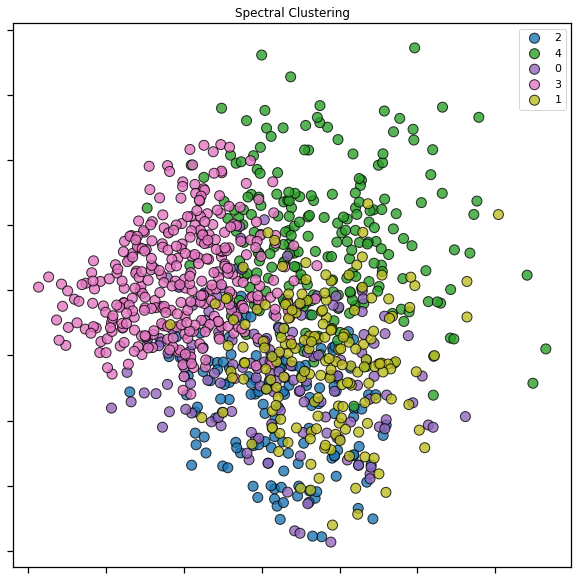

In [115]:
plot_vectors(X2[sample], "Spectral Clustering", labels=spc_sample_ids, dimensions=2)

### K-means

Chose spectral clustering because you can choose the number of clusters and because it's for large sample size with medium number of clusters.

In [116]:
km = KMeans(n_clusters=5, random_state=0)
km_sample_ids = km.fit_predict(X2[sample])

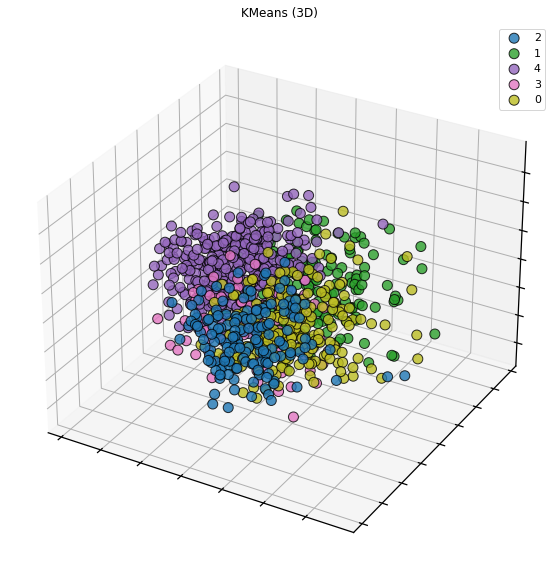

In [117]:
plot_vectors(X2[sample], "KMeans (3D)", labels=km_sample_ids)

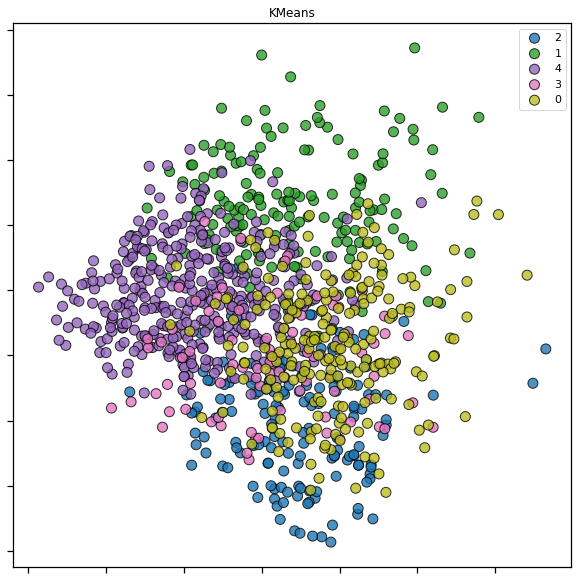

In [118]:
plot_vectors(X2[sample], "KMeans", labels=km_sample_ids, dimensions=2)

### Comparing clustering methods

Here we will make the assumption that the first one is the action, the comedy, drama, horror and finally thriller.

In [119]:
genres_id = []
for i in range(len(genres)):
    if (genres[i]=="action"):
        genres_id.append(0)
    elif (genres[i]=="comedy"):
        genres_id.append(1)
    elif (genres[i]=="drama"):
        genres_id.append(2)
    elif (genres[i]=="horror"):
        genres_id.append(3)
    elif (genres[i]=="thriller"):
        genres_id.append(4)

In [120]:
clusters = pd.DataFrame()
clusters['Genres'] = genres
clusters['Genres ID'] = genres_id
clusters['Agglomerative Clustering'] = agg_sample_ids
clusters['Spectral Clustering'] = spc_sample_ids
clusters['KMeans'] = km_sample_ids

In [121]:
clusters

Genres  Genres ID  Agglomerative Clustering  Spectral Clustering  \
0      action          0                         1                    2   
1      action          0                         0                    4   
2      action          0                         2                    4   
3      action          0                         0                    4   
4      action          0                         1                    2   
..        ...        ...                       ...                  ...   
995  thriller          4                         2                    0   
996  thriller          4                         2                    0   
997  thriller          4                         0                    4   
998  thriller          4                         2                    4   
999  thriller          4                         0                    2   

     KMeans  
0         2  
1         1  
2         1  
3         1  
4         2  
..      ...  
995       0  
996       3  
997       0  
998       0  
999       4  

[1000 rows x 5 columns]

Now we will use some measure to compare the algorithms. Explanation for the metrics is given directly from https://scikit-learn.org/.

Rand index adjusted for chance.

The Rand Index computes a similarity measure between two clusterings by considering all pairs of samples and counting pairs that are assigned in the same or different clusters in the predicted and true clusterings.

In [122]:
print("For Agglomerative Clustering adjusted rand score is: ", metrics.adjusted_rand_score(np.array(clusters['Genres ID']), clusters['Agglomerative Clustering']))
print("For Spectral Clustering adjusted rand score is: ", metrics.adjusted_rand_score(np.array(clusters['Genres ID']), clusters['Spectral Clustering']))
print("For KMeans adjusted rand score is: ", metrics.adjusted_rand_score(np.array(clusters['Genres ID']), clusters['KMeans']))

For Agglomerative Clustering adjusted rand score is:  0.07954356141584565
For Spectral Clustering adjusted rand score is:  0.10882261086792665
For KMeans adjusted rand score is:  0.10787531628777054


Adjusted Mutual Information (AMI) is an adjustment of the Mutual Information (MI) score to account for chance. It accounts for the fact that the MI is generally higher for two clusterings with a larger number of clusters, regardless of whether there is actually more information shared.

In [123]:
print("For Agglomerative Clustering the adjusted mutual info score is: ", metrics.adjusted_mutual_info_score(np.array(clusters['Genres ID']), clusters['Agglomerative Clustering']))
print("For Spectral Clustering the adjusted mutual info score is: ", metrics.adjusted_mutual_info_score(np.array(clusters['Genres ID']), clusters['Spectral Clustering']))
print("For KMeans the adjusted mutual info score is: ", metrics.adjusted_mutual_info_score(np.array(clusters['Genres ID']), clusters['KMeans']))

For Agglomerative Clustering the adjusted mutual info score is:  0.1112288949471746
For Spectral Clustering the adjusted mutual info score is:  0.14432377640224656
For KMeans the adjusted mutual info score is:  0.13658664423575978


V-measure cluster labeling given a ground truth.

This score is identical to normalized_mutual_info_score with the 'arithmetic' option for averaging.

The V-measure is the harmonic mean between homogeneity and completeness

In [124]:
print("For Agglomerative Clustering v measure score is: ", metrics.v_measure_score(np.array(clusters['Genres ID']), clusters['Agglomerative Clustering']))
print("For Spectral Clustering v measure score is: ", metrics.v_measure_score(np.array(clusters['Genres ID']), clusters['Spectral Clustering']))
print("For KMeans v measure score is: ", metrics.v_measure_score(np.array(clusters['Genres ID']), clusters['KMeans']))

For Agglomerative Clustering v measure score is:  0.11677130173632662
For Spectral Clustering v measure score is:  0.14868537125820822
For KMeans v measure score is:  0.14107546929057133


We can observe that clearly the Spectral cluster and kmeans seem to be much better.

<a id='conclusion'></a>
# 3. Conclusion
[Back to table of contents](#home)

What we have noticed throughout this analysis is that generally there seems to be differences between the different genres. However, very often, key terms to explain plots show up very often and tend to make it more difficult to differentiate between each genre. Additionally, it can often be the case that similar words will be used, but just the emphasis of one specific word will lead to a totally different genre such as "kill" or "death" that we have been able to observe in topic models. 